# Contents

- [Setup](#Setup)
    - [Read Data](#Read-Data)
    - [Bad Column Names](#Bad-Column-Names)
    - [Choice of Columns](#Choice-of-Columns)
    - [Datatypes](#Datatypes)
    - [Constant Columns](#Constant-Columns)
    - [Categoricals](#Categoricals)
    - [Singular Gram Matrix](#Singular-Gram-Matrix)
    - [Duplicate Columns](#Duplicate-Columns)
    - [Duplicate Rows](#Duplicate-Rows)
- [Univariate](#Univariate)
    - [Missing Values](#Missing-Values)
    - [Contingency Table](#Contingency-Table)
    - [Numeric Distribution](#Numeric-Distribution)
    - [Numeric Descriptive Statistics](#Numeric-Descriptive-Statistics)
    - [Categorical Frequency Distribution](#Categorical-Frequency-Distribution)
    - [Categorical Contingency Tables](#Categorical-Contingency-Tables)

- [Bivariate](#Bivariate)
    - [Correlation Matrix](#Correlation-Matrix)
    - [Scatter Plot Matrix](#Scatter-Plot-Matrix)
    - [Multicollinearity](#Multicollinearity)
    - [Bivariate Contingency Tables](#Bivariate-Contingency-Tables)
    - [Bivariate Contingency Heatmaps](#Bivariate-Contingency-Heatmaps)
    - [Bivariate Stacked Bar Charts](#Bivariate-Stacked-Bar-Charts)
    - [Chi Square Test](#Chi-Square-Test)
    - [Categorical Numeric Interaction](#Categorical-Numeric-Interaction)
        - [Summary Stats by Category](#Summary-Stats-by-Category)
        - [Boxplot](#Boxplot)
        - [ANOVA](#ANOVA)
        - [Mean Plots](#Mean-Plots)
        - [Correlation by Category](#Correlation-by-Category)


# Setup

#### `Read Data`

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('dataset.csv')
df.head()

,ID,Age,Salary,Department,Join_Date,Is_Manager,Performance_Score,City,Years_with_Company,Has_Certification
0,1,56,63906.507294,Marketing,2010-01-01,0,8.720483,San Francisco,10,False
1,2,69,97462.046998,Marketing,2010-01-02,1,5.272262,San Francisco,1,True
2,3,46,65369.050408,Finance,2010-01-03,1,6.325441,Los Angeles,3,False
3,4,32,104624.779864,HR,2010-01-04,0,6.444703,Seattle,0,False
4,5,60,81217.332225,HR,2010-01-05,1,8.197978,San Francisco,1,True


[Back to the top](#Contents)

#### `Bad Column Names`

In [2]:
import re

def to_snake_case(s):
    """
    Convert a string to snake_case.

    Parameters:
        s (str): The input string.

    Returns:
        str: The string converted to snake_case.
    """
    s = re.sub(r'\W+', '_', s)  # Replace non-word characters with '_'
    s = s.strip('_')           # Remove leading or trailing underscores
    return s.lower()

def rename_columns_to_snake_case(df):
    """
    Rename the DataFrame columns to snake_case and warn if column names are changed.

    Parameters:
        df (pd.DataFrame): The input DataFrame.

    Returns:
        pd.DataFrame: The DataFrame with renamed columns.
    """
    # Original column names
    original_columns = df.columns
    
    # New column names in snake_case
    new_columns = [to_snake_case(col) for col in original_columns]
    
    # Check for changes
    changes = [(old, new) for old, new in zip(original_columns, new_columns) if old != new]
    
    # Update column names
    df.columns = new_columns
    
    # Warn if any column names were changed
    if changes:
        print("\033[91mWarning: Column names changed to snake_case.\033[0m")
        for old, new in changes:
            print(f"\033[91m{old} -> {new}\033[0m")
    else:
        print("\033[92mNo changes to column names. All columns are already in snake_case.\033[0m")
    
    return df

# Example usage
df = rename_columns_to_snake_case(df)


ID -> id
Age -> age
Salary -> salary
Department -> department
Join_Date -> join_date
Is_Manager -> is_manager
Performance_Score -> performance_score
City -> city
Years_with_Company -> years_with_company
Has_Certification -> has_certification


[Back to the top](#Contents)

#### `Choice of Columns`

In [4]:
ignore_columns = ['id', 'join_date']
numeric_columns = [col for col in df.columns if df[col].dtype in ['int64', 'float64'] and col not in ignore_columns]
numeric_columns = [x for x in numeric_columns if x not in ['is_manager']]

categorical_columns = [col for col in df.columns if col not in ignore_columns + numeric_columns]
# categorical_columns = categorical_columns + ['Is_Manager']

print("Ignored Columns:", ignore_columns)
print("Numeric Columns:", numeric_columns)
print("Categorical Columns:", categorical_columns)

df.drop(ignore_columns, inplace=True, axis = 1)
df.head()

Ignored Columns: ['id', 'join_date']
Numeric Columns: ['age', 'salary', 'performance_score', 'years_with_company']
Categorical Columns: ['department', 'is_manager', 'city', 'has_certification']


,age,salary,department,is_manager,performance_score,city,years_with_company,has_certification
0,56,63906.507294,Marketing,0,8.720483,San Francisco,10,False
1,69,97462.046998,Marketing,1,5.272262,San Francisco,1,True
2,46,65369.050408,Finance,1,6.325441,Los Angeles,3,False
3,32,104624.779864,HR,0,6.444703,Seattle,0,False
4,60,81217.332225,HR,1,8.197978,San Francisco,1,True


[Back to the top](#Contents)

#### `Datatypes`

In [6]:
df_datatypes = df.dtypes.to_frame().T
df_datatypes

,age,salary,department,is_manager,performance_score,city,years_with_company,has_certification
0,int64,float64,object,int64,float64,object,int64,bool


[Back to the top](#Contents)

#### `Constant Columns`

In [7]:
from colorama import Fore, Style

# Find columns with only one unique value
constant_columns = df.nunique()[df.nunique() == 1].index

# Check if there are any constant columns
if not constant_columns.empty:
    print(f"{Fore.RED}Warning: The following columns are constant: {list(constant_columns)}{Style.RESET_ALL}")
else:
    print("No constant columns found.")


No constant columns found.


[Back to the top](#Contents)

#### `Categoricals`

In [8]:
df.nunique().to_frame().T

,age,salary,department,is_manager,performance_score,city,years_with_company,has_certification
0,62,1000,4,2,1000,5,15,2


In [9]:
def detect_categorical_columns(df, percentage_threshold=0.05):
    """
    Detect categorical columns based on the percentage of unique values.

    Parameters:
        df (pd.DataFrame): The DataFrame to analyze.
        percentage_threshold (float): The maximum percentage of unique values relative to the number of rows 
                                       for a column to be considered categorical (e.g., 0.1 for 10%).

    Returns:
        list: A list of column names detected as categorical.
    """
    # Calculate the threshold based on the percentage of rows
    unique_threshold = len(df) * percentage_threshold
    
    # Identify columns with unique values less than or equal to the threshold
    categorical_columns = df.columns[df.nunique() <= unique_threshold]
    return list(categorical_columns)

# Example usage
categorical_cols = detect_categorical_columns(df, percentage_threshold=0.1)

# Display the detected categorical columns
print(f"Categorical columns: {categorical_cols}")


Categorical columns: ['age', 'department', 'is_manager', 'city', 'years_with_company', 'has_certification']


[Back to the top](#Contents)

#### `Singular Gram Matrix`

In [10]:
import numpy as np
import pandas as pd

def check_gram_matrix_singularity(df):
    """
    Check if the Gram matrix (dot product of df and its transpose) is singular.
    Warn the user if the determinant is zero. Only numeric columns are considered.

    Parameters:
        df (pd.DataFrame): Input data matrix.

    Returns:
        float: Determinant of the Gram matrix.
    """
    # Select only numeric columns
    numeric_df = df.select_dtypes(include=[np.number])
    
    if numeric_df.empty:
        print("\033[93mWarning: No numeric columns found in the DataFrame.\033[0m")
        return None

    # Compute the Gram matrix
    gram_matrix = np.dot(numeric_df, numeric_df.T)
    
    # Calculate the determinant
    determinant = np.linalg.det(gram_matrix)
    
    # Check for singularity
    if np.isclose(determinant, 0):  # Use np.isclose to handle floating-point precision
        print("\033[91mWarning: The Gram matrix is singular (determinant is 0).\033[0m")
    else:
        print("\033[92mThe Gram matrix is not singular. Determinant: {:.6f}\033[0m".format(determinant))
    
    return determinant

check_gram_matrix_singularity(df)


-0.0

[Back to the top](#Contents)

#### `Duplicate Columns`

In [11]:
def find_duplicate_columns(df):
    """
    Find duplicate columns in a DataFrame and print a red warning if duplicates are found.

    Parameters:
        df (pd.DataFrame): The DataFrame to check for duplicate columns.

    Returns:
        list: A list of tuples, where each tuple contains the names of duplicate columns.
    """
    duplicate_columns = []
    columns = df.columns
    
    # Check for duplicate columns
    for i in range(len(columns)):
        for j in range(i + 1, len(columns)):
            if df[columns[i]].equals(df[columns[j]]):
                duplicate_columns.append((columns[i], columns[j]))
    
    # Display warning if duplicates are found
    if duplicate_columns:
        print("\033[91mWarning: Duplicate columns found:\033[0m")
        for col_pair in duplicate_columns:
            print(f"\033[91m{col_pair[0]} is identical to {col_pair[1]}.\033[0m")
    else:
        print("\033[92mNo duplicate columns found.\033[0m")
    
    return duplicate_columns

find_duplicate_columns(df)

No duplicate columns found.


[]

[Back to the top](#Contents)

#### `Duplicate Rows`

In [12]:
def check_duplicated_rows(df):
    """
    Check for duplicated rows in the DataFrame and display a strict warning if duplicates are found.

    Parameters:
        df (pd.DataFrame): The DataFrame to check for duplicated rows.

    Returns:
        int: The number of duplicated rows in the DataFrame.
    """
    # Count duplicated rows
    duplicate_count = df.duplicated().sum()
    
    if duplicate_count > 0:
        print(f"\033[91mWarning: {duplicate_count} duplicated rows found in the DataFrame.\033[0m")
        print("\033[91mConsider reviewing and removing duplicates if necessary.\033[0m")
    else:
        print("\033[92mNo duplicated rows found in the DataFrame.\033[0m")
    
    return duplicate_count

check_duplicated_rows(df)



No duplicated rows found in the DataFrame.


0

___
[Back to the top](#Contents)

# Univariate

#### `Missing Values`

In [13]:
def check_missing_values(df):
    """
    Check for missing values in each column of the DataFrame and return the results
    as a single-row DataFrame. Display a warning if missing values are found.

    Parameters:
        df (pd.DataFrame): The input DataFrame.

    Returns:
        pd.DataFrame: A single-row DataFrame showing the count of missing values in each column.
    """
    # Calculate missing values for each column
    missing_values = df.isnull().sum().to_frame().T
    
    # Check if there are any missing values
    total_missing = missing_values.sum(axis=1).values[0]
    
    if total_missing > 0:
        print("\033[91mWarning: Missing values detected in the DataFrame.\033[0m")
        print(f"\033[91mTotal missing values: {int(total_missing)}\033[0m")
        print(f"\033[91mColumns with missing values:\033[0m")
        for col, count in missing_values.items():
            if count.iloc[0] > 0:
                print(f"\033[91m{col}: {count.iloc[0]} missing values\033[0m")
    else:
        print("\033[92mNo missing values detected in the DataFrame.\033[0m")
    
    return missing_values

# Example usage
check_missing_values(df)


No missing values detected in the DataFrame.


,age,salary,department,is_manager,performance_score,city,years_with_company,has_certification
0,0,0,0,0,0,0,0,0


[Back to the top](#Contents)

#### `Contingency Table`

In [14]:
import pandas as pd
import openpyxl
from openpyxl.utils import get_column_letter

def generate_contingency_table(dataset, output_filename="", maximum_entries=2**20, format_width=True,
                               sl_no_required=True, frequency_required=True, percentage_required=True,
                               cumulative_percentage_required=False, string_length_required=True):
    """
    Generate frequency tables for each column in a DataFrame and save them to an Excel file.

    Parameters:
    ----------
    dataset : pandas.DataFrame
        The input DataFrame containing the data to analyze.

    output_filename : str, optional
        The name of the output Excel file (should end in ".xlsx"). If not provided, the function will generate a default
        filename in the format "frequency_table_<timestamp>.xlsx".

    maximum_entries : int, optional
        Maximum number of unique entries to include in the output for each column. Default is 2^20 (1,048,576).

    format_width : bool, optional
        If True, auto-formats the width of the columns in the output Excel file. Default is True.

    sl_no_required : bool, optional
        If True, includes a serial number column in the output. Default is True.

    frequency_required : bool, optional
        If True, includes a frequency column in the output. Default is True.

    percentage_required : bool, optional
        If True, includes a percentage column in the output. Default is True.

    cumulative_percentage_required : bool, optional
        If True, includes a cumulative percentage column in the output. Default is False.

    string_length_required : bool, optional
        If True, includes a string length column in the output. Default is True.

    Returns:
    -------
    None
        The function does not return anything; it writes the results directly to the specified Excel file.
    """
    
    # Setting default output filename
    if output_filename == "":
        output_filename = f"frequency_table_{pd.Timestamp.now().strftime('%Y%m%d_%H%M%S')}.xlsx"
    if not output_filename.endswith(".xlsx"):
        output_filename = f"{output_filename}.xlsx"
    
    print(f"Writing frequency table of dataset to {output_filename}\n")
    
    # Creating the Excel writer object
    with pd.ExcelWriter(output_filename, engine='openpyxl') as writer:
        
        for col in dataset.columns:
            sheet_name = col if len(col) <= 31 else f"{col[:15]}{col[-16:]}"
            
            # Calculating frequency table
            frequency_table = dataset[col].value_counts().reset_index()
            frequency_table.columns = [col, 'frequency']
            frequency_table = frequency_table.sort_values(by='frequency', ascending=False)
            
            # Calculating additional columns
            if percentage_required:
                frequency_table['percentage'] = 100 * frequency_table['frequency'] / frequency_table['frequency'].sum()
            if cumulative_percentage_required:
                frequency_table['cumulative_percentage'] = frequency_table['percentage'].cumsum()
            if sl_no_required:
                frequency_table['sl_no'] = range(1, len(frequency_table) + 1)
            if string_length_required:
                frequency_table['string_length'] = frequency_table[col].astype(str).apply(len)
            
            # Reordering columns
            column_order = ['sl_no', col, 'frequency'] if sl_no_required else [col, 'frequency']
            if percentage_required:
                column_order.append('percentage')
            if cumulative_percentage_required:
                column_order.append('cumulative_percentage')
            if string_length_required:
                column_order.append('string_length')
            
            frequency_table = frequency_table[column_order].head(maximum_entries)
            
            # Write the data to Excel
            frequency_table.to_excel(writer, sheet_name=sheet_name, index=False)
            sheet = writer.sheets[sheet_name]
            
            # Auto-adjust column widths
            if format_width:
                for i, col_name in enumerate(frequency_table.columns):
                    max_length = max(frequency_table[col_name].astype(str).map(len).max(), len(col_name))
                    sheet.column_dimensions[get_column_letter(i + 1)].width = max_length + 2

            # Print correct column name
            print(f"Generated Contingency Table for column: {col}")
    
    print(f"\nFrequency table saved to {output_filename}")

generate_contingency_table(df, output_filename="contingency_table.xlsx")

Writing frequency table of dataset to contingency_table.xlsx

Generated Contingency Table for column: age
Generated Contingency Table for column: salary
Generated Contingency Table for column: department
Generated Contingency Table for column: is_manager
Generated Contingency Table for column: performance_score
Generated Contingency Table for column: city
Generated Contingency Table for column: years_with_company
Generated Contingency Table for column: has_certification

Frequency table saved to contingency_table.xlsx


[Back to the top](#Contents)

#### `Numeric Distribution`

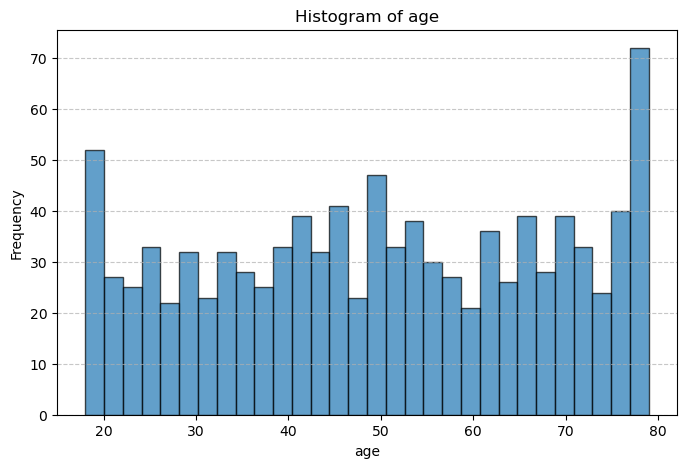

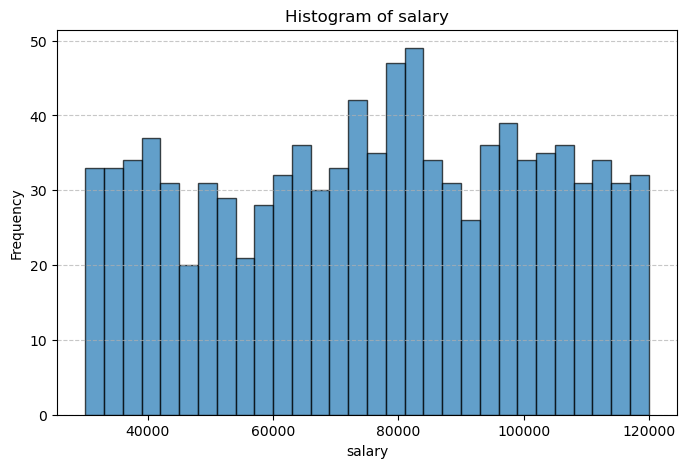

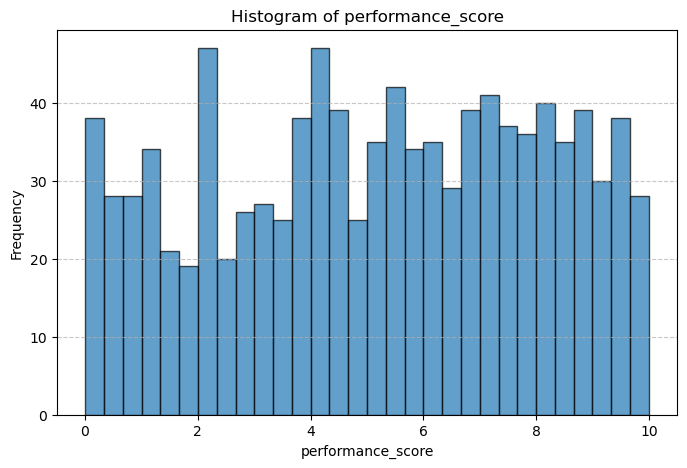

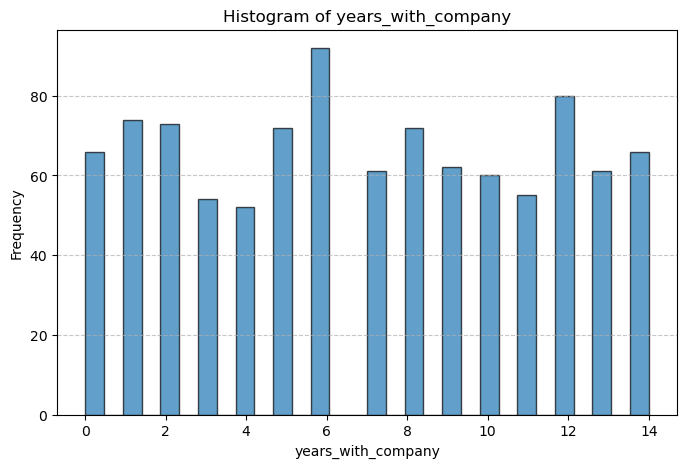

In [15]:
import matplotlib.pyplot as plt

# Create histograms for numeric columns
for col in numeric_columns:
    plt.figure(figsize=(8, 5))
    plt.hist(df[col].dropna(), bins=30, edgecolor='black', alpha=0.7)  # Drop NaN for plotting
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


[Back to the top](#Contents)

#### `Numeric Descriptive Statistics`

In [16]:
df[numeric_columns].describe()

,age,salary,performance_score,years_with_company
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,49.857000,75968.578017,5.198456,6.945000
std,18.114267,25589.150274,2.840250,4.315159
min,18.000000,30021.377122,0.004428,0.000000
25%,35.000000,54411.873051,2.827381,3.000000
50%,50.000000,77727.878686,5.397738,7.000000
75%,66.000000,97505.268896,7.626393,11.000000
max,79.000000,119941.814961,9.995439,14.000000


[Back to the top](#Contents)

#### `Categorical Frequency Distribution`

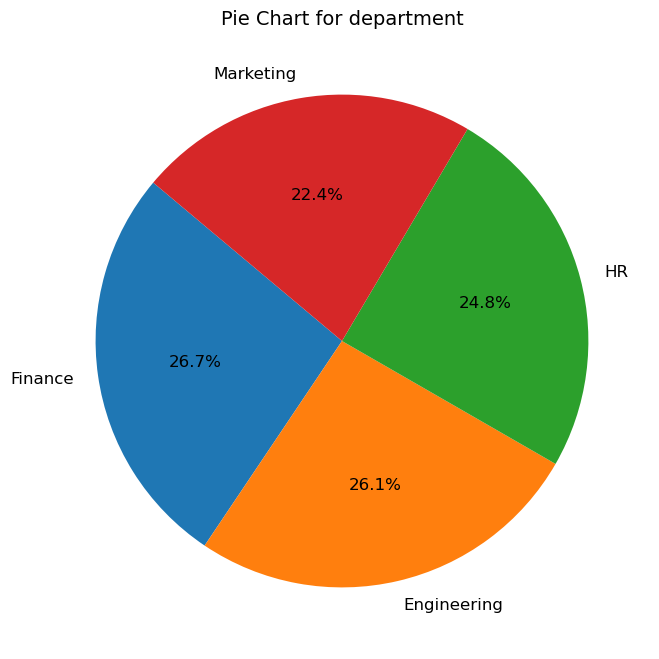

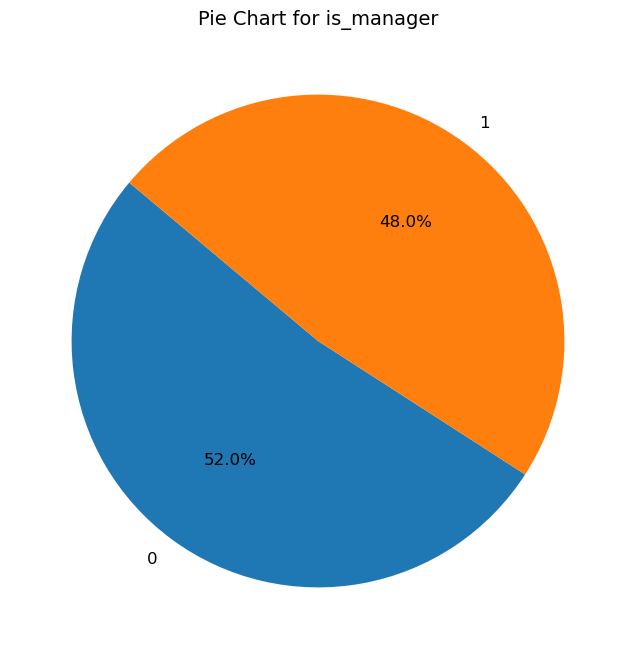

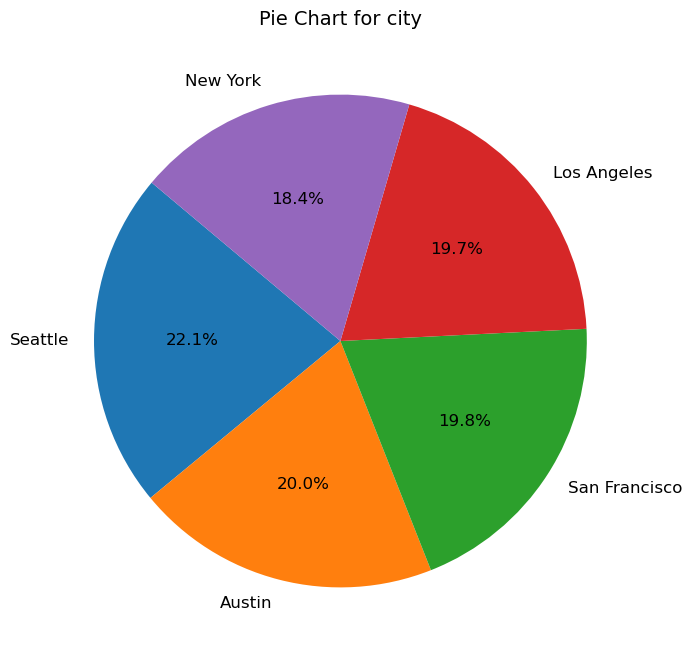

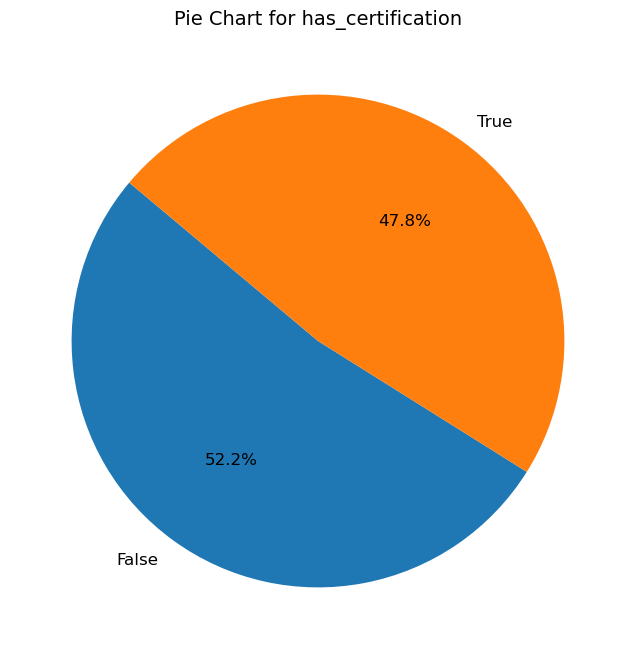

In [17]:
import matplotlib.pyplot as plt

# Plot pie charts for each categorical column
for col in categorical_columns:
    # Generate contingency table including missing values
    contingency_table = df[col].value_counts(dropna=False)
    
    # Plot the pie chart
    plt.figure(figsize=(8, 8))
    plt.pie(
        contingency_table.values,
        labels=contingency_table.index,
        autopct='%1.1f%%',
        startangle=140,
        textprops={'fontsize': 12}
    )
    plt.title(f"Pie Chart for {col}", fontsize=14)
    plt.show()


[Back to the top](#Contents)

#### `Categorical Contingency Tables`

In [18]:
# Generate contingency tables with counts and percentages for categorical columns
contingency_tables = {}

for col in categorical_columns:
    contingency_table = df[col].value_counts(dropna=False).to_frame(name='Count')
    contingency_table['Percentage'] = (df[col].value_counts(normalize=True, dropna=False) * 100).round(2)
    contingency_tables[col] = contingency_table

# Display contingency tables
for col, table in contingency_tables.items():
    print(f"Contingency Table for {col}:\n")
    print(table)
    print("\n" + "-"*50 + "\n")


Contingency Table for department:

             Count  Percentage
department                    
Finance        267        26.7
Engineering    261        26.1
HR             248        24.8
Marketing      224        22.4

--------------------------------------------------

Contingency Table for is_manager:

            Count  Percentage
is_manager                   
0             520        52.0
1             480        48.0

--------------------------------------------------

Contingency Table for city:

               Count  Percentage
city                            
Seattle          221        22.1
Austin           200        20.0
San Francisco    198        19.8
Los Angeles      197        19.7
New York         184        18.4

--------------------------------------------------

Contingency Table for has_certification:

                   Count  Percentage
has_certification                   
False                522        52.2
True                 478        47.8

--------------

___
[Back to the top](#Contents)

# Bivariate

#### `Correlation Matrix`

/opt/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


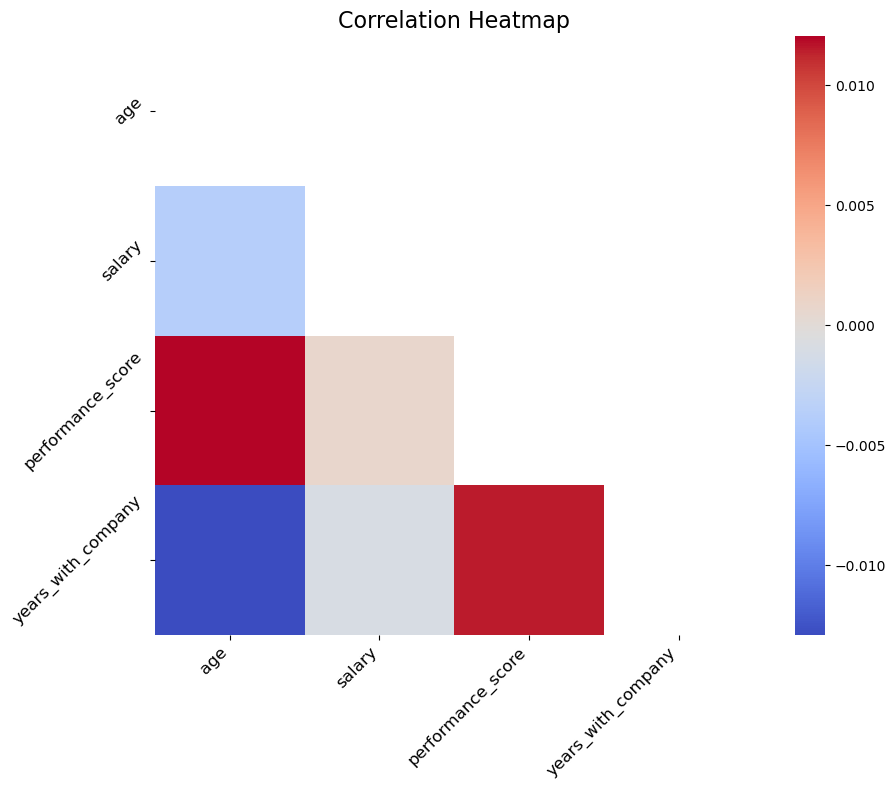

In [19]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
correlation_matrix = df[numeric_columns].corr()

# Mask the upper triangle of the matrix
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix,
    mask=mask, 
    annot=True, 
    fmt='.2f', 
    cmap='coolwarm', 
    square=True, 
    cbar=True
)

# Add large circles around specific correlations (excluding diagonal)
ax = plt.gca()  # Get the current axis
for i in range(len(correlation_matrix)):
    for j in range(i):  # Exclude diagonal by using `i` instead of `i + 1`
        val = correlation_matrix.iloc[i, j]
        if val > 0.70 or val < -0.70:  # Highlight condition
            # Add a circle
            circle = plt.Circle((j + 0.5, i + 0.5), 0.3, color='black', fill=False, linewidth=2)
            ax.add_artist(circle)

# Set x-axis labels with diagonal rotation
plt.xticks(rotation=45, ha='right', fontsize=12)

# Set y-axis labels with diagonal rotation
plt.yticks(rotation=45, ha='right', fontsize=12)

plt.title("Correlation Heatmap", fontsize=16)
plt.tight_layout()
plt.show()


[Back to the top](#Contents)

#### `Scatter Plot Matrix`

<Figure size 1200x1200 with 0 Axes>

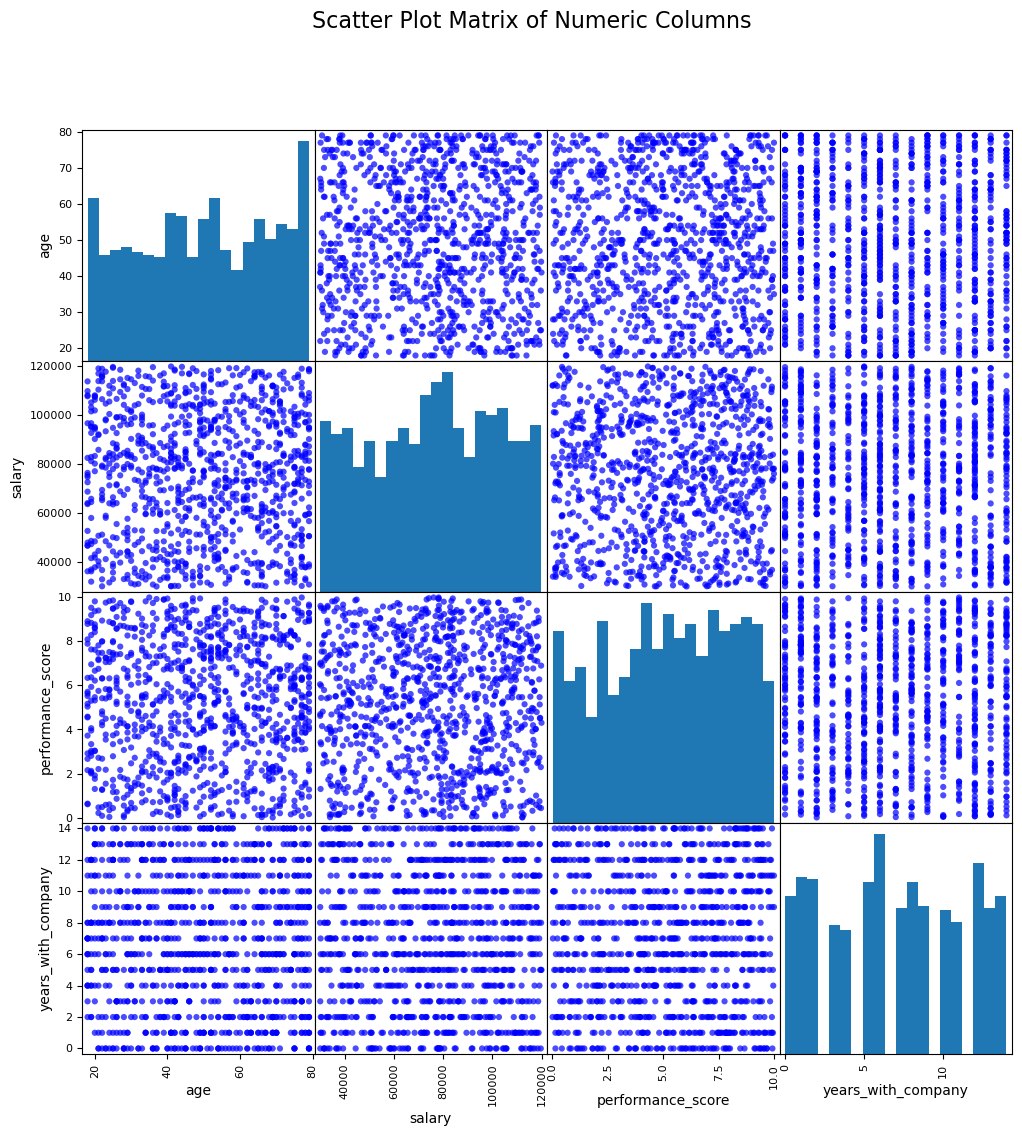

In [20]:
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt

# Scatter plot matrix for numeric columns
plt.figure(figsize=(12, 12))
scatter_matrix(
    df[numeric_columns],  # Numeric columns only
    figsize=(12, 12),     # Size of the entire plot
    diagonal='hist',      # Use histograms for diagonal elements
    alpha=0.7,            # Transparency for better overlap visibility
    marker='o',           # Marker style
    hist_kwds={'bins': 20}, # Adjust histogram bins
    s=20,                 # Marker size
    color='blue'          # Marker color
)
plt.suptitle("Scatter Plot Matrix of Numeric Columns", fontsize=16)
plt.show()

[Back to the top](#Contents)

#### `Multicollinearity`

Multicollinearity occurs when two or more predictor variables in a regression model are highly correlated. This means that one predictor variable can be linearly predicted from the others with a substantial degree of accuracy.

---

Why is Multicollinearity a Problem?  
1. Inflated Variance:  
   - Multicollinearity increases the variance of the regression coefficients, making them unstable and difficult to interpret.  
2. Redundancy:  
   - Highly correlated predictors provide overlapping information, which can lead to redundancy in the model.  
3. Impact on Statistical Significance:  
   - High multicollinearity can cause significant predictors to appear insignificant due to inflated standard errors.

How is Multicollinearity Detected?  
1. Correlation Matrix:  
   - Identify pairs of predictors with high absolute correlation (e.g., |correlation| > 0.8).  
2. Variance Inflation Factor (VIF):  
   - VIF quantifies the extent of multicollinearity for each predictor.

Formula for Variance Inflation Factor (VIF):  
The Variance Inflation Factor (VIF) is calculated using the formula:

$$ \text{VIF}_i = \frac{1}{1 - R_i^2} $$

Where: $R_i^2$ is the coefficient of determination when predictor $X_i$ is regressed on all other predictors.

VIF Interpretation:  
- VIF = 1: No multicollinearity.  
- VIF > 5: Moderate to high multicollinearity.  
- VIF > 10: Severe multicollinearity.

How to Address Multicollinearity?  
1. Remove Redundant Predictors:  
   - Drop one of the correlated variables based on domain knowledge or predictive importance.  
2. Feature Transformation:  
   - Combine correlated features or apply techniques like Principal Component Analysis (PCA) to reduce dimensionality.  
3. Regularization:  
   - Use regression techniques like Ridge or Lasso to mitigate the effects of multicollinearity.


In [21]:
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Correlation Matrix
def calculate_correlation_matrix(numeric_df):
    correlation_matrix = numeric_df.corr()
    print("Correlation Matrix:")
    print(correlation_matrix)
    return correlation_matrix

# VIF Calculation
def calculate_vif(numeric_df):
    vif_data = pd.DataFrame()
    vif_data['Feature'] = numeric_df.columns
    vif_data['VIF'] = [variance_inflation_factor(numeric_df.values, i) for i in range(numeric_df.shape[1])]
    return vif_data

# Apply the functions
drop_columns = []
numeric_df = df[[x for x in numeric_columns if x not in drop_columns]]  # Subset of numeric columns

# 1. Calculate the Correlation Matrix
correlation_matrix = calculate_correlation_matrix(numeric_df)

# 2. Highlight Highly Correlated Features (Threshold: 0.8 or higher)
high_correlation_pairs = []
threshold = 0.8
for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            high_correlation_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j], correlation_matrix.iloc[i, j]))

print("\nHighly Correlated Pairs (|correlation| > 0.8):")
for pair in high_correlation_pairs:
    print(f"{pair[0]} and {pair[1]}: {pair[2]:.2f}")

# 3. Calculate Variance Inflation Factor (VIF)
vif_results = calculate_vif(numeric_df)
print("\nVariance Inflation Factor (VIF):")
print(vif_results)

# Highlight features with VIF > 5 (common threshold)
high_vif_features = vif_results[vif_results['VIF'] > 5]
print("\nFeatures with High VIF (VIF > 5):")
print(high_vif_features)



Correlation Matrix:
                         age    salary  performance_score  years_with_company
age                 1.000000 -0.003718           0.012033           -0.012920
salary             -0.003718  1.000000           0.000665           -0.000956
performance_score   0.012033  0.000665           1.000000            0.011506
years_with_company -0.012920 -0.000956           0.011506            1.000000

Highly Correlated Pairs (|correlation| > 0.8):

Variance Inflation Factor (VIF):
              Feature       VIF
0                 age  5.775902
1              salary  6.083591
2   performance_score  3.765482
3  years_with_company  3.185872

Features with High VIF (VIF > 5):
  Feature       VIF
0     age  5.775902
1  salary  6.083591


[Back to the top](#Contents)

#### `Bivariate Contingency Tables`

In [23]:
# List of columns to exclude from analysis
exclude_columns = ['Join_Date']  # Add column names you want to exclude, e.g., ['Column1', 'Column2']

# Filter the categorical columns by excluding specified columns
filtered_categorical_columns = [col for col in categorical_columns if col not in exclude_columns]

# Generate contingency tables for the filtered columns
for i, col1 in enumerate(filtered_categorical_columns):
    for col2 in filtered_categorical_columns[i + 1:]:
        print(f"Contingency Table for {col1} vs {col2}:\n")
        crosstab = pd.crosstab(df[col1], df[col2])
        print(crosstab)
        print("\n" + "-"*50 + "\n")


Contingency Table for department vs is_manager:

is_manager     0    1
department           
Engineering  147  114
Finance      126  141
HR           136  112
Marketing    111  113

--------------------------------------------------

Contingency Table for department vs city:

city         Austin  Los Angeles  New York  San Francisco  Seattle
department                                                        
Engineering      52           56        50             43       60
Finance          54           53        49             57       54
HR               47           54        41             55       51
Marketing        47           34        44             43       56

--------------------------------------------------

Contingency Table for department vs has_certification:

has_certification  False  True 
department                     
Engineering          143    118
Finance              140    127
HR                   127    121
Marketing            112    112

-------------------

[Back to the top](#Contents)

#### `Bivariate Contingency Heatmaps`

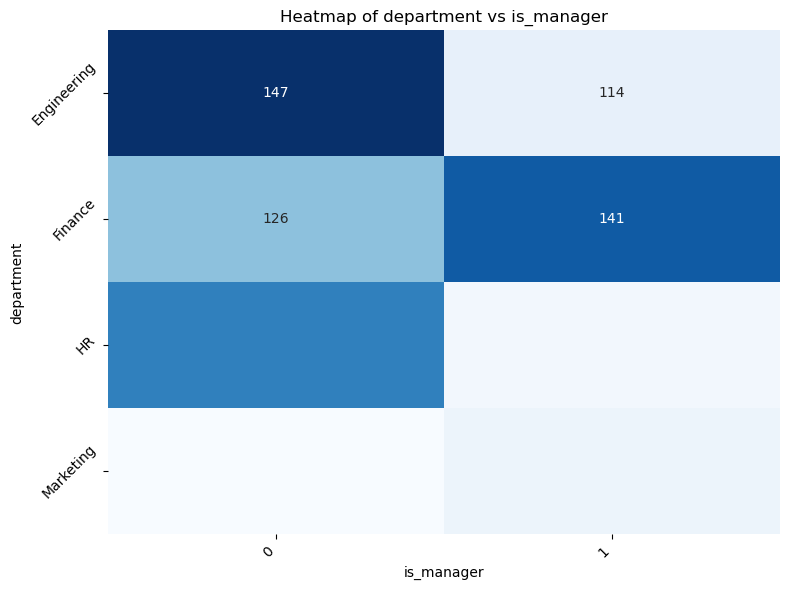

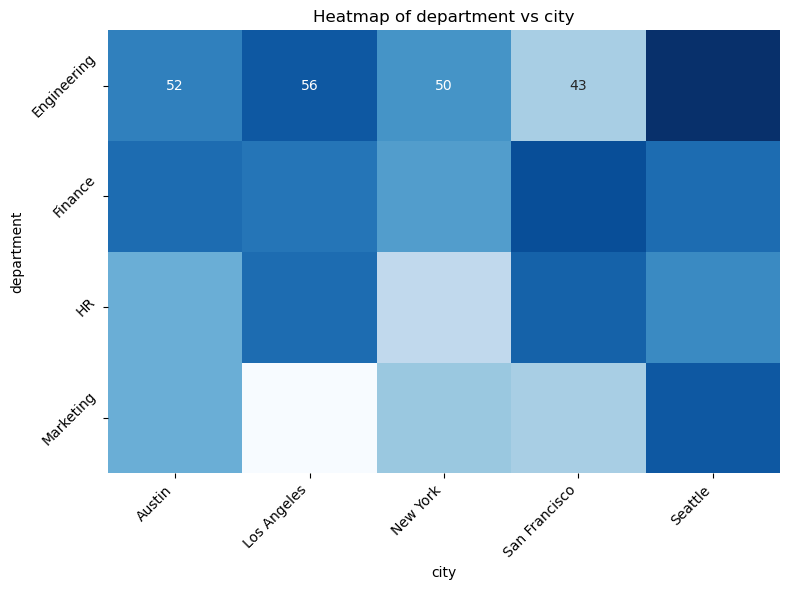

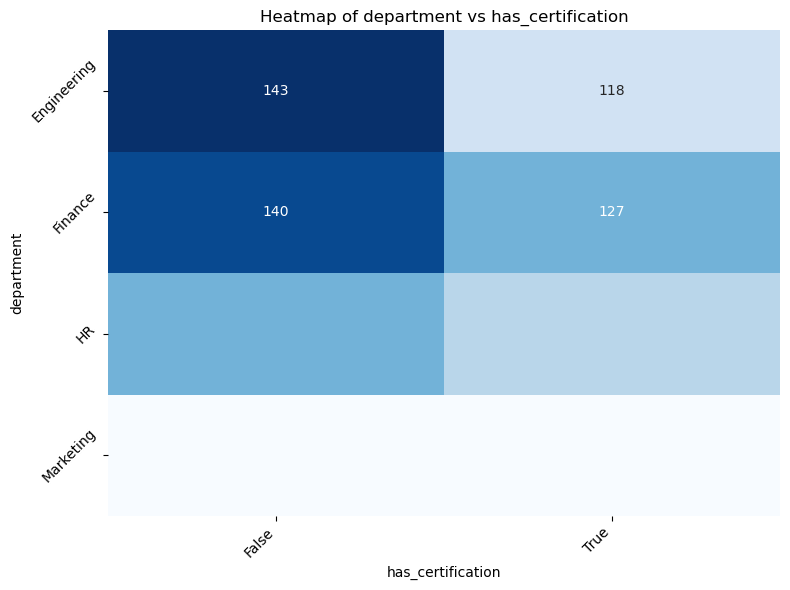

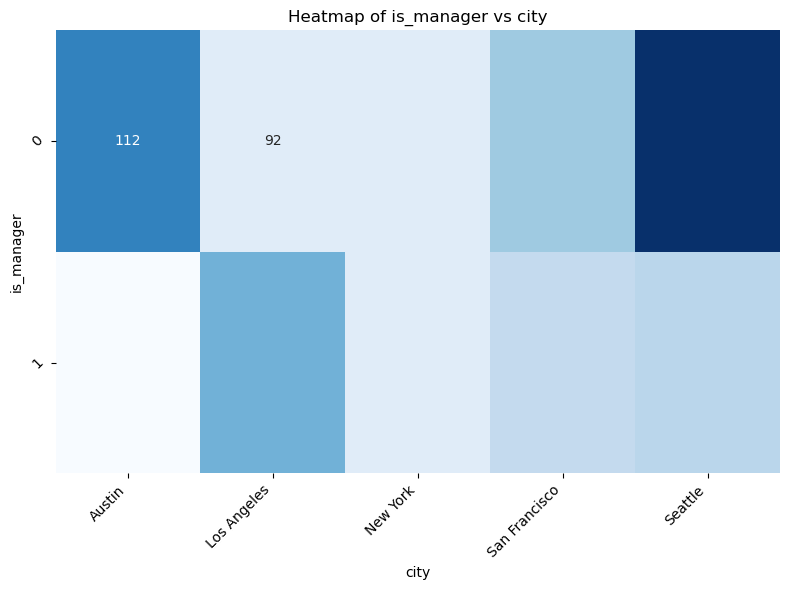

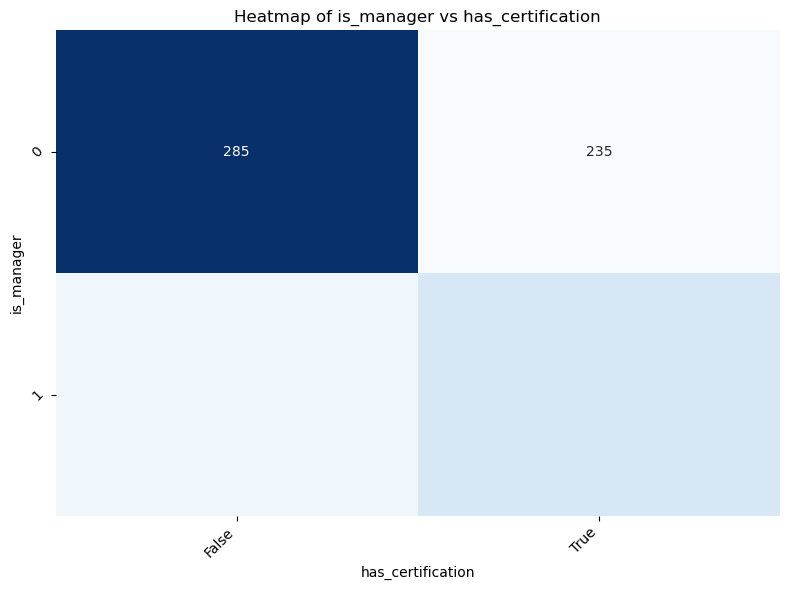

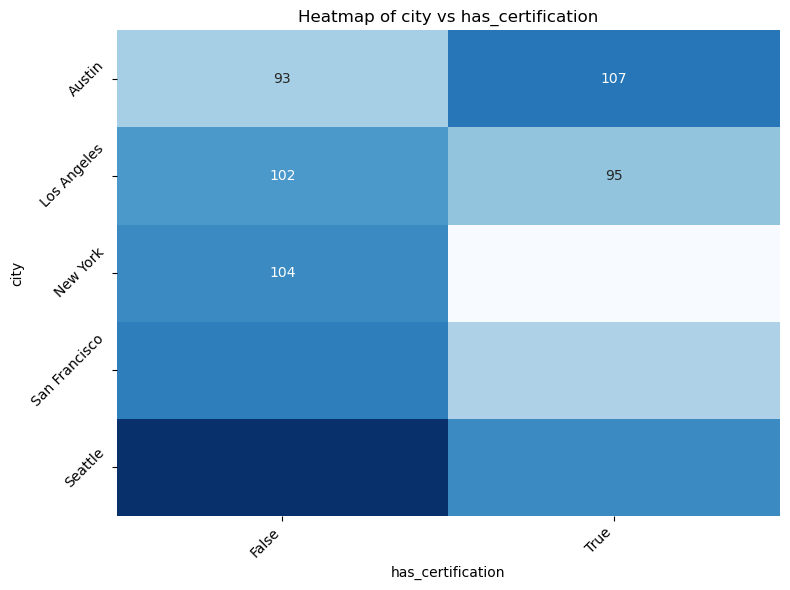

In [24]:
exclude_columns = ['Join_Date'] # List of columns to exclude from analysis

filtered_categorical_columns = [col for col in categorical_columns if col not in exclude_columns]
# Generate heatmaps for contingency tables of the filtered columns
for i, col1 in enumerate(filtered_categorical_columns):
    for col2 in filtered_categorical_columns[i + 1:]:
        crosstab = pd.crosstab(df[col1], df[col2])
        
        # Plot the heatmap
        plt.figure(figsize=(8, 6))
        sns.heatmap(crosstab, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title(f"Heatmap of {col1} vs {col2}")
        plt.xlabel(col2)
        plt.ylabel(col1)
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=45, ha='right')  # Ensure diagonal style for y-axis labels
        plt.tight_layout()
        plt.show()


[Back to the top](#Contents)

#### `Bivariate Stacked Bar Charts`

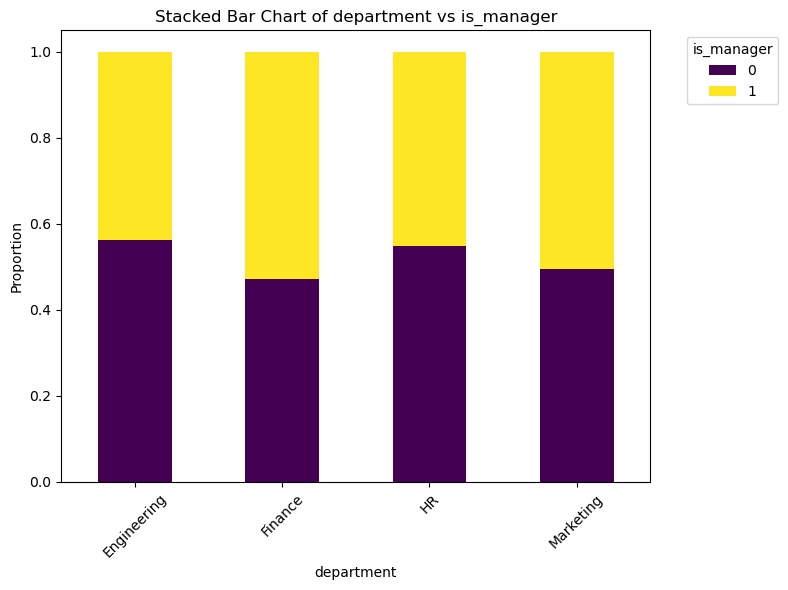

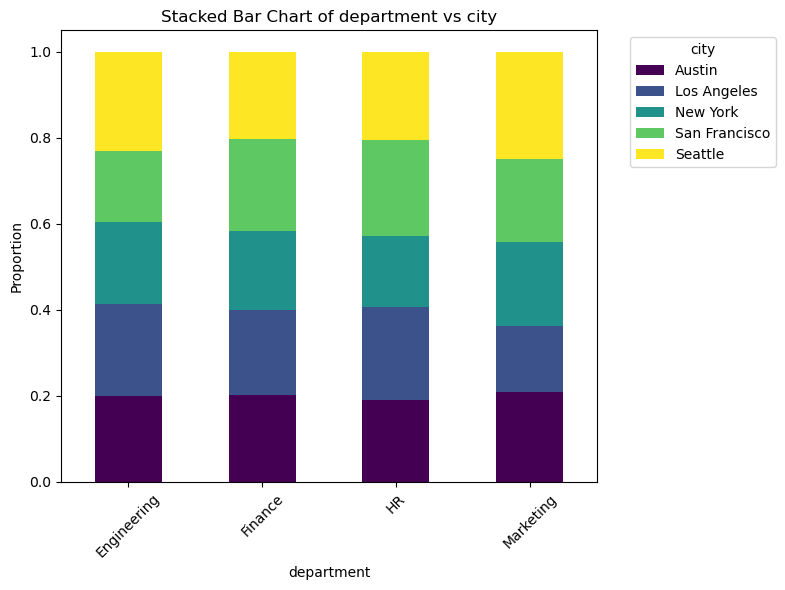

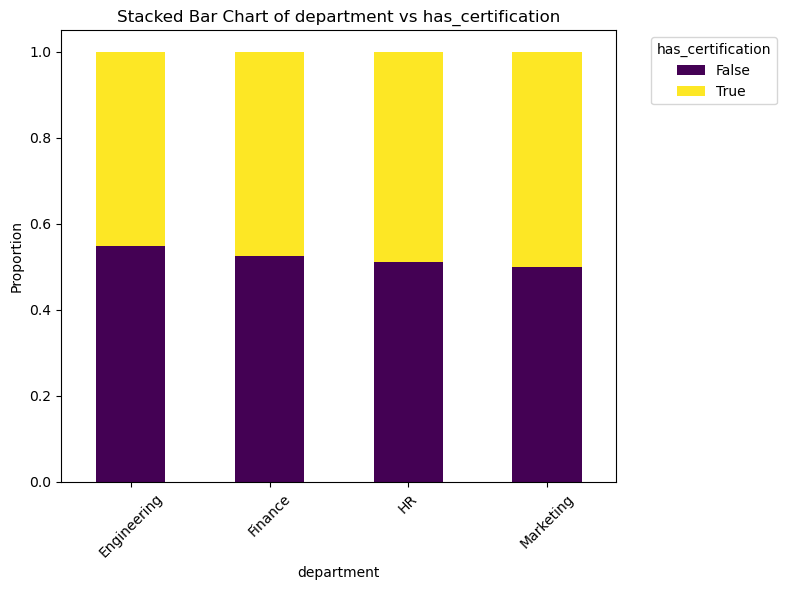

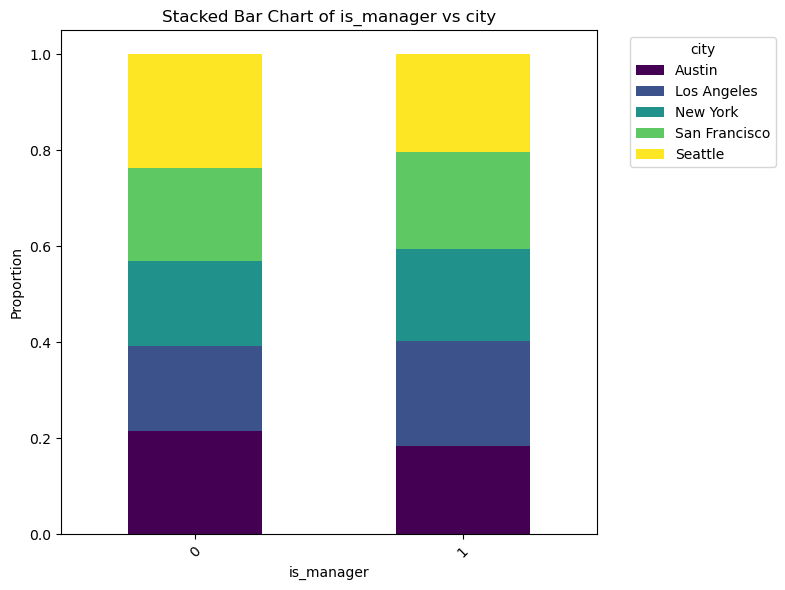

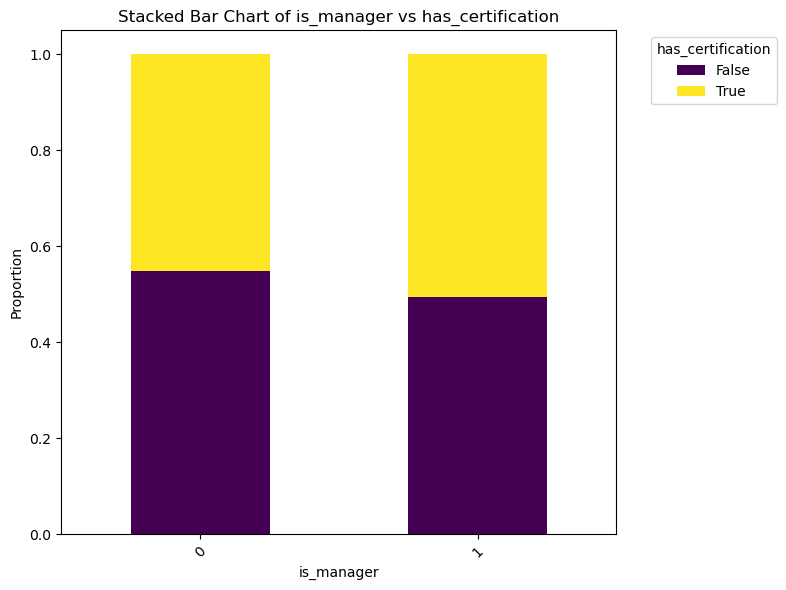

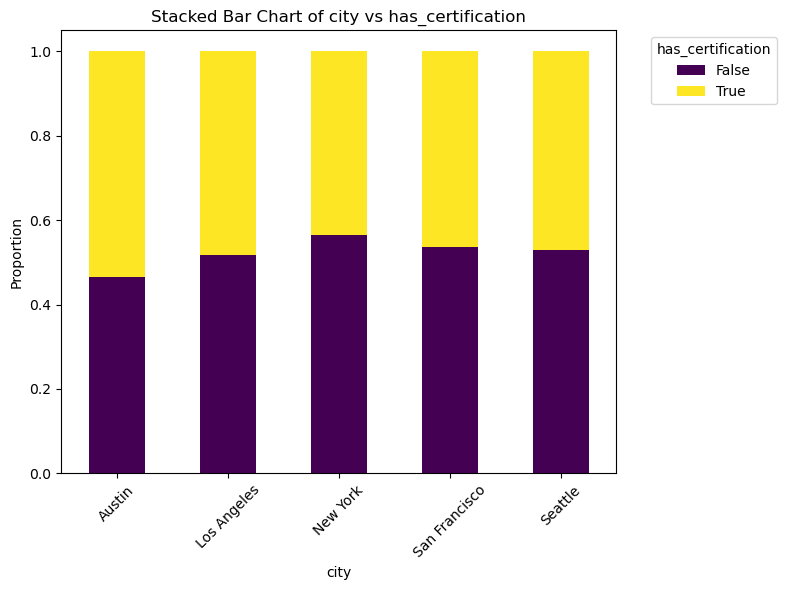

In [25]:
exclude_columns = ['Join_Date'] # List of columns to exclude from analysis

filtered_categorical_columns = [col for col in categorical_columns if col not in exclude_columns]
# Generate stacked bar charts for the filtered columns
for i, col1 in enumerate(filtered_categorical_columns):
    for col2 in filtered_categorical_columns[i + 1:]:
        crosstab = pd.crosstab(df[col1], df[col2], normalize='index')  # Normalize by rows
        
        # Plot the stacked bar chart
        crosstab.plot(kind='bar', stacked=True, figsize=(8, 6), colormap='viridis')
        plt.title(f"Stacked Bar Chart of {col1} vs {col2}")
        plt.xlabel(col1)
        plt.ylabel("Proportion")
        plt.xticks(rotation=45)
        plt.legend(title=col2, bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()


[Back to the top](#Contents)

#### `Chi Square Test`
- for testing association

In [26]:
from scipy.stats import chi2_contingency
from IPython.display import display, HTML


# List of columns to exclude from analysis
exclude_columns = []  # Add column names to exclude, e.g., ['Column1', 'Column2']

# Filter the categorical columns by excluding specified columns
filtered_categorical_columns = [col for col in categorical_columns if col not in exclude_columns]

# Perform Chi-Square Test for filtered column pairs
for i, col1 in enumerate(filtered_categorical_columns):
    for col2 in filtered_categorical_columns[i + 1:]:
        crosstab = pd.crosstab(df[col1], df[col2])
        chi2, p, dof, expected = chi2_contingency(crosstab)
        
        # Print results
        print(f"Chi-Square Test for {col1} vs {col2}:\n")
        print(f"Chi-Square Statistic: {chi2:.2f}")
        print(f"p-value: {p:.4f}")
        print(f"Degrees of Freedom: {dof}")
        print("\nExpected Frequencies:\n", expected)
        
        # Conclusion
        if p < 0.05:
            display(HTML(f"<p style='color:red;'>Conclusion: {col1} and {col2} are likely associated (p < 0.05).</p>"))
        else:
            display(HTML(f"<p>Conclusion: {col1} and {col2} are likely independent (p >= 0.05).</p>"))
        
        print("-" * 50 + "\n")


Chi-Square Test for department vs is_manager:

Chi-Square Statistic: 5.76
p-value: 0.1236
Degrees of Freedom: 3

Expected Frequencies:
 [[135.72 125.28]
 [138.84 128.16]
 [128.96 119.04]
 [116.48 107.52]]


--------------------------------------------------

Chi-Square Test for department vs city:

Chi-Square Statistic: 8.43
p-value: 0.7503
Degrees of Freedom: 12

Expected Frequencies:
 [[52.2   51.417 48.024 51.678 57.681]
 [53.4   52.599 49.128 52.866 59.007]
 [49.6   48.856 45.632 49.104 54.808]
 [44.8   44.128 41.216 44.352 49.504]]


--------------------------------------------------

Chi-Square Test for department vs has_certification:

Chi-Square Statistic: 1.24
p-value: 0.7436
Degrees of Freedom: 3

Expected Frequencies:
 [[136.242 124.758]
 [139.374 127.626]
 [129.456 118.544]
 [116.928 107.072]]


--------------------------------------------------

Chi-Square Test for is_manager vs city:

Chi-Square Statistic: 5.05
p-value: 0.2817
Degrees of Freedom: 4

Expected Frequencies:
 [[104.   102.44  95.68 102.96 114.92]
 [ 96.    94.56  88.32  95.04 106.08]]


--------------------------------------------------

Chi-Square Test for is_manager vs has_certification:

Chi-Square Statistic: 2.74
p-value: 0.0979
Degrees of Freedom: 1

Expected Frequencies:
 [[271.44 248.56]
 [250.56 229.44]]


--------------------------------------------------

Chi-Square Test for city vs has_certification:

Chi-Square Statistic: 4.19
p-value: 0.3814
Degrees of Freedom: 4

Expected Frequencies:
 [[104.4    95.6  ]
 [102.834  94.166]
 [ 96.048  87.952]
 [103.356  94.644]
 [115.362 105.638]]


--------------------------------------------------



[Back to the top](#Contents)

#### `Categorical Numeric Interaction`

#### `Summary Stats` by Category

In [27]:
for col in categorical_columns:
    print(f"Summary Statistics for Numeric Columns Grouped by {col}:\n")
    grouped_stats = df.groupby(col)[numeric_columns].describe()
    print(grouped_stats)
    print("\n" + "-"*50 + "\n")


Summary Statistics for Numeric Columns Grouped by department:

               age                                                       \
             count       mean        std   min   25%   50%    75%   max   
department                                                                
Engineering  261.0  49.674330  18.252431  18.0  34.0  50.0  66.00  79.0   
Finance      267.0  49.483146  18.553993  18.0  33.0  49.0  66.00  79.0   
HR           248.0  50.649194  17.416601  18.0  38.0  50.0  66.00  79.0   
Marketing    224.0  49.638393  18.274404  18.0  35.0  49.0  65.25  79.0   

            salary                ... performance_score            \
             count          mean  ...               75%       max   
department                        ...                               
Engineering  261.0  74936.586266  ...          7.150387  9.995439   
Finance      267.0  77028.737018  ...          7.680475  9.946486   
HR           248.0  74304.918630  ...          7.647396  9.994662 

[Back to the top](#Contents)

#### `Boxplot`
Distribution of numeric features for each category of the categorical variable

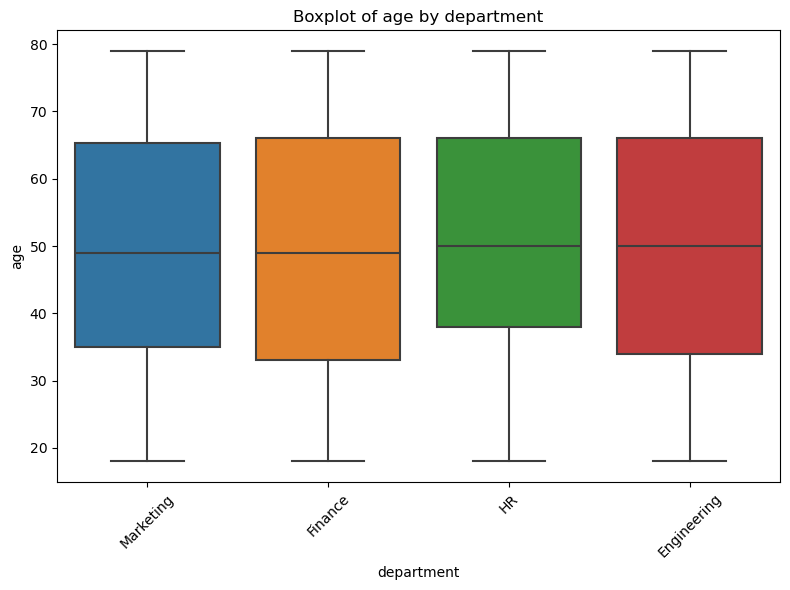

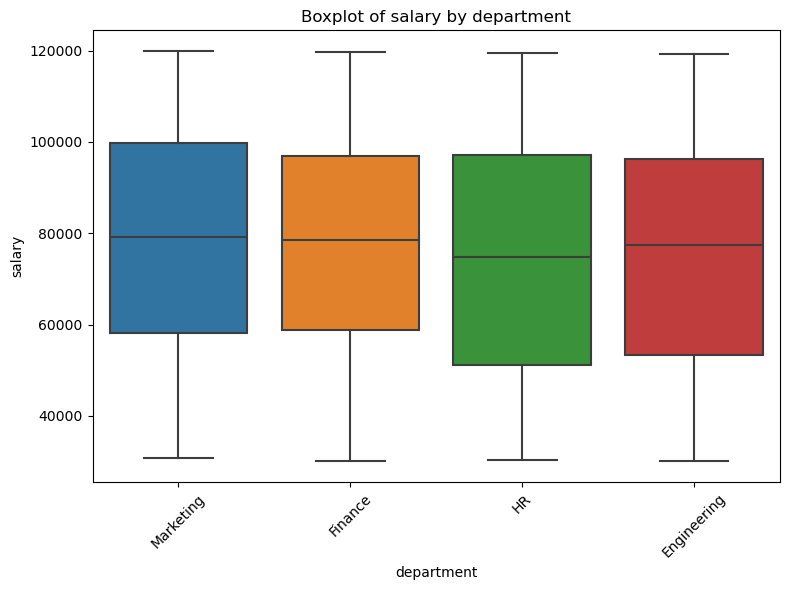

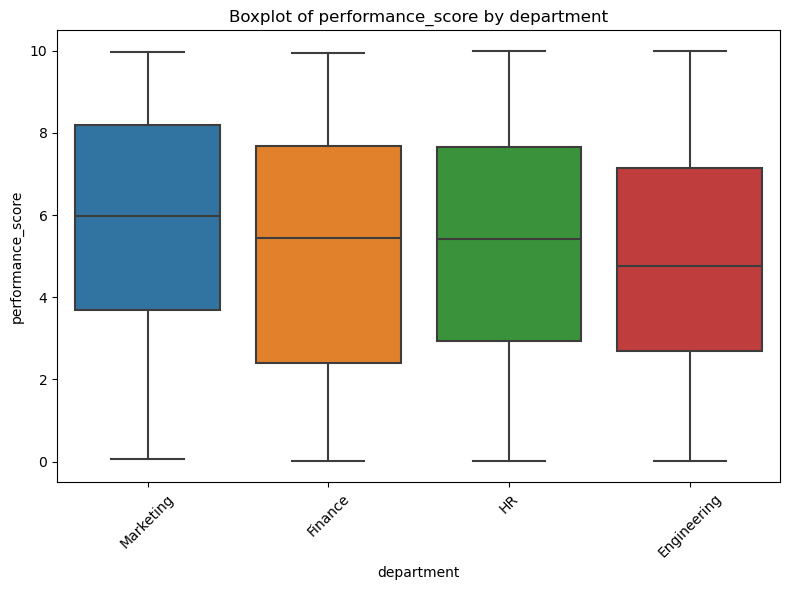

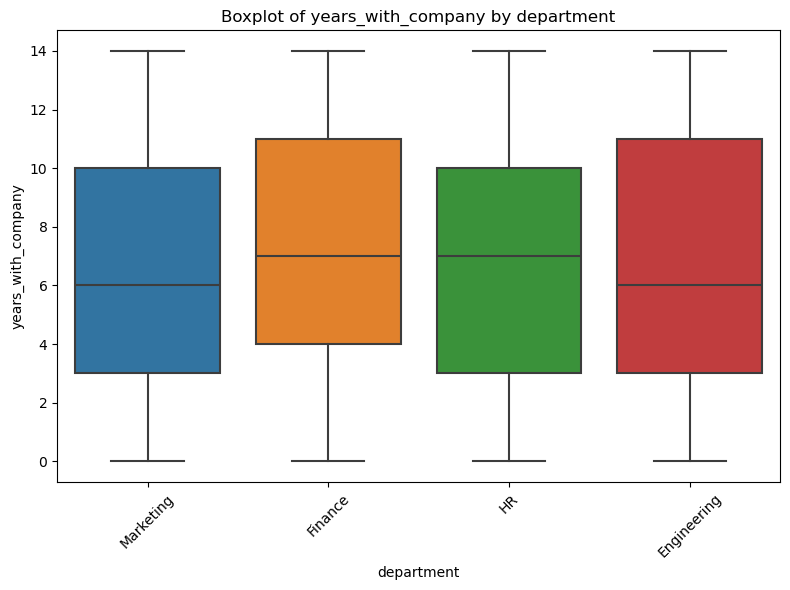

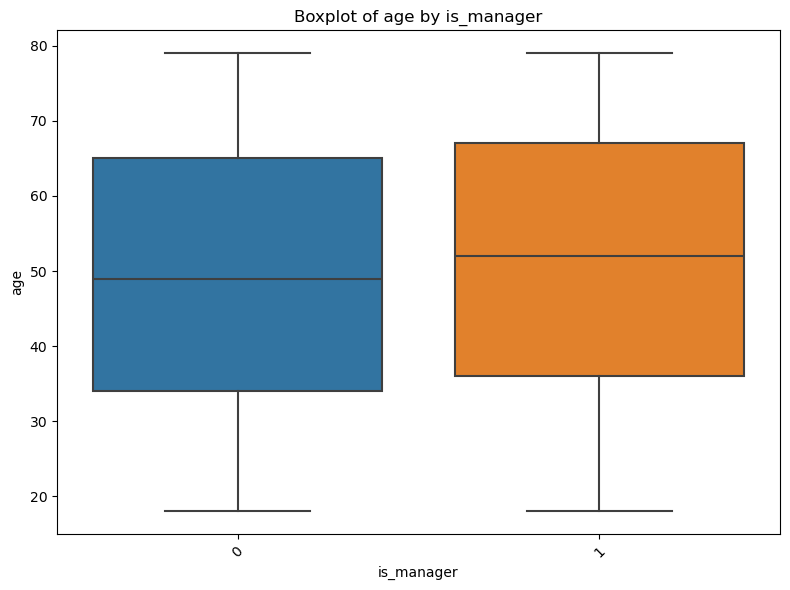

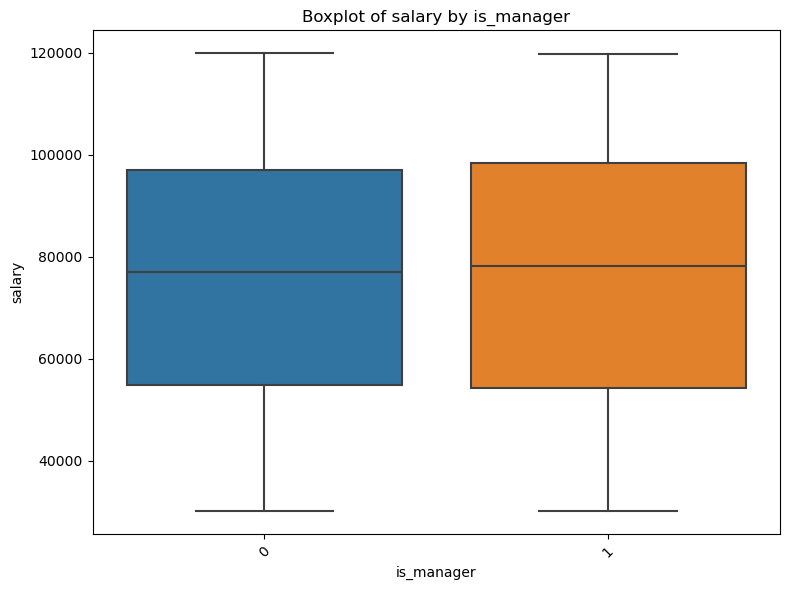

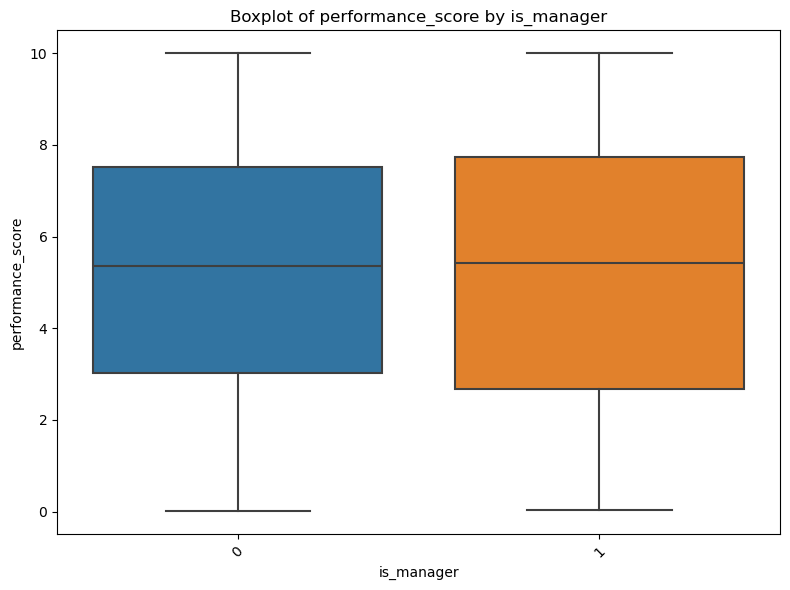

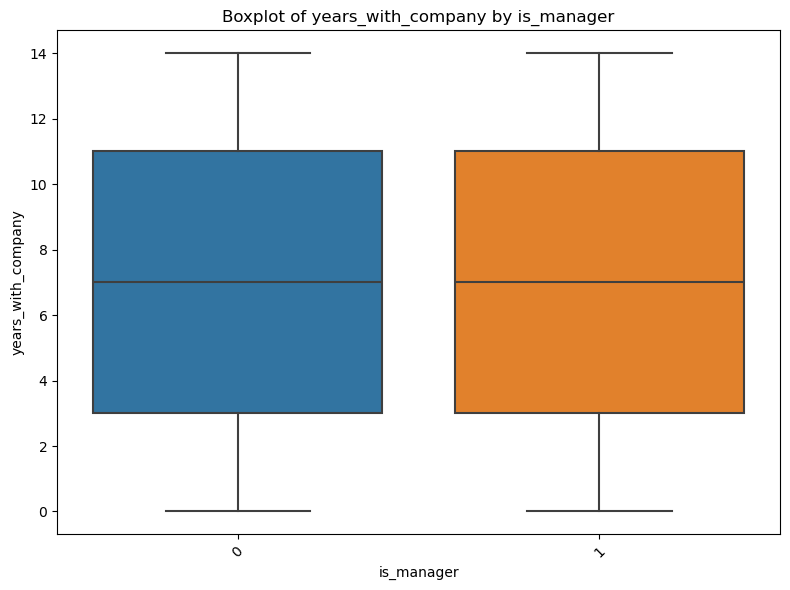

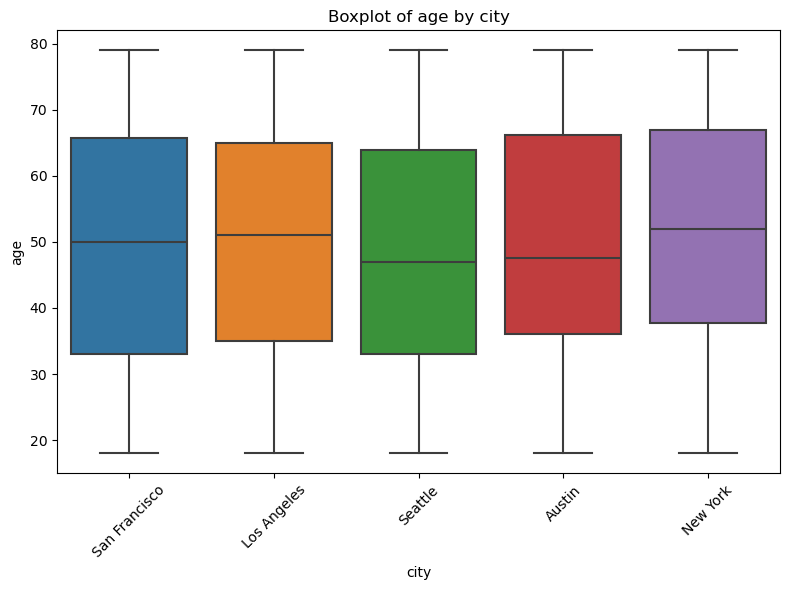

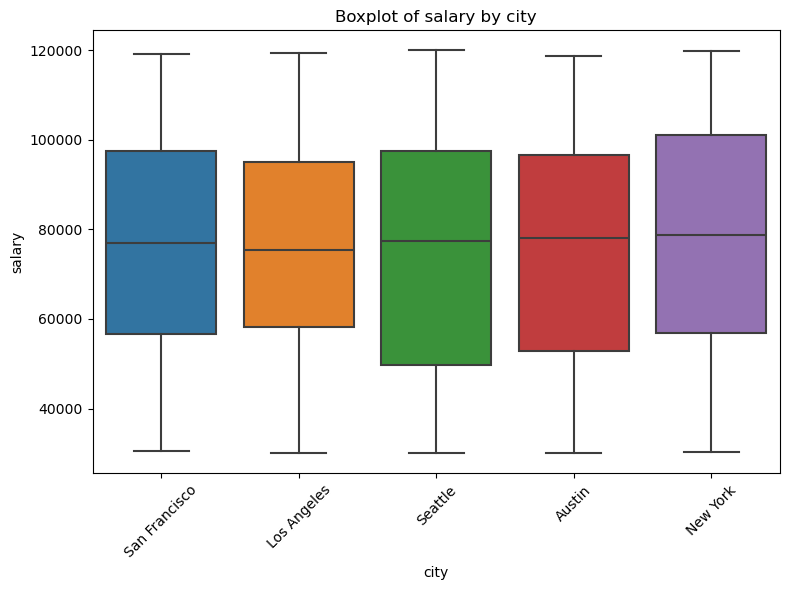

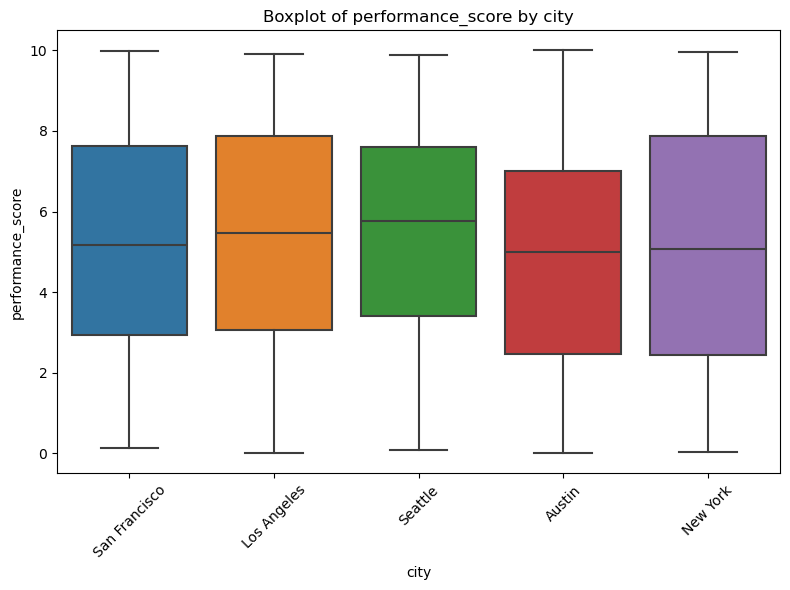

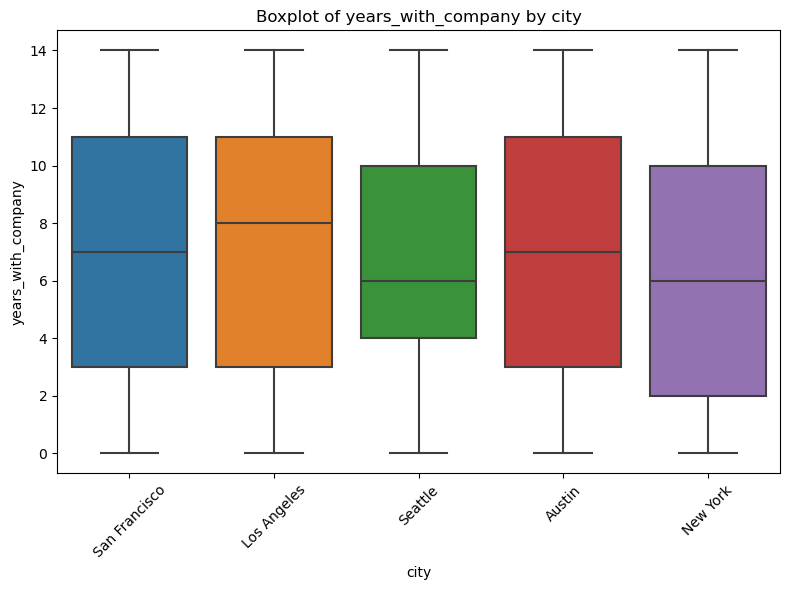

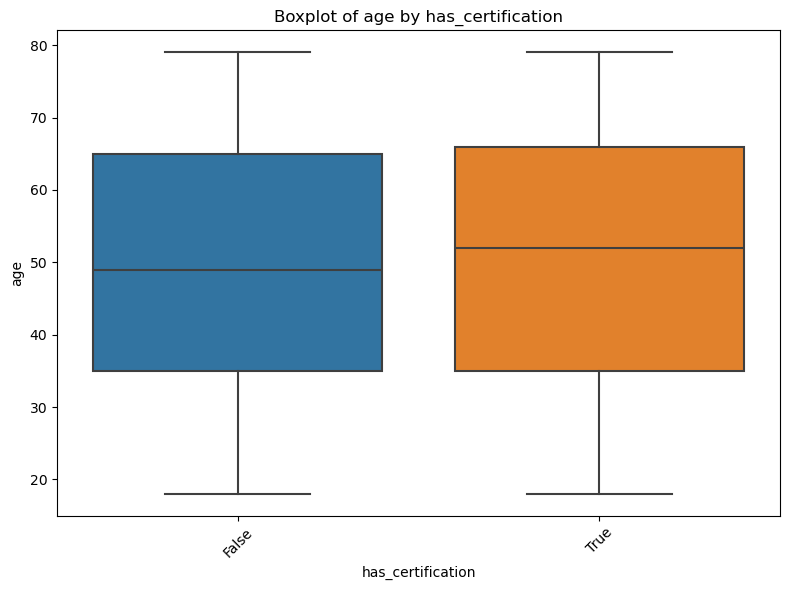

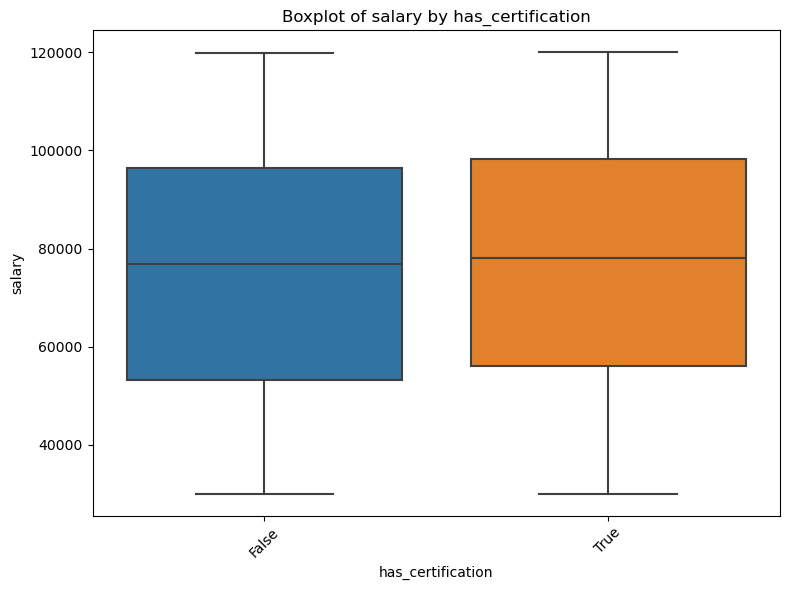

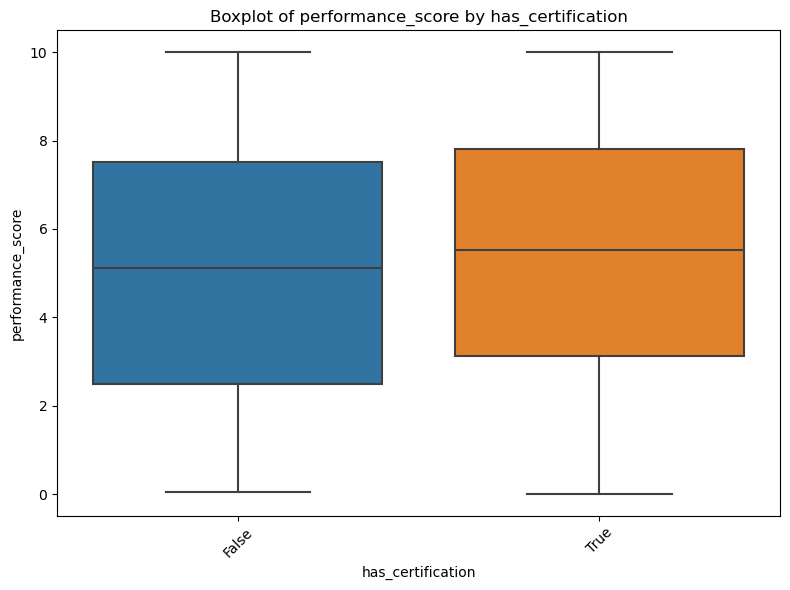

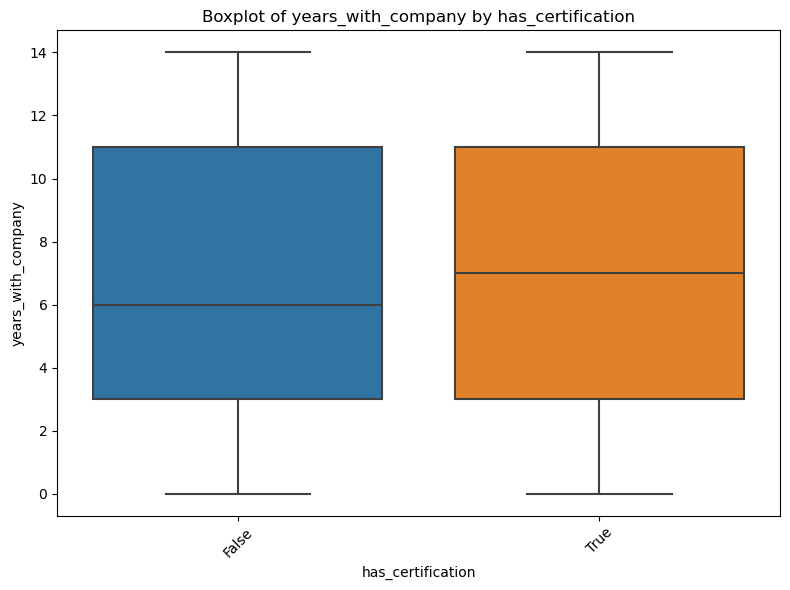

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

for col in categorical_columns:
    for num_col in numeric_columns:
        plt.figure(figsize=(8, 6))
        sns.boxplot(x=df[col], y=df[num_col])
        plt.title(f"Boxplot of {num_col} by {col}")
        plt.xlabel(col)
        plt.ylabel(num_col)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()


[Back to the top](#Contents)

#### `ANOVA` 
Test if the mean of a numeric feature differs significantly across categories.

In [29]:
from scipy.stats import f_oneway

for col in categorical_columns:
    for num_col in numeric_columns:
        groups = [df[num_col][df[col] == cat] for cat in df[col].unique()]
        f_stat, p_value = f_oneway(*groups)
        print(f"ANOVA for {num_col} by {col}:\nF-Statistic: {f_stat:.2f}, p-value: {p_value:.4f}\n")
        if p_value < 0.05:
            print(f"Conclusion: Significant differences in {num_col} across {col} categories (p < 0.05).\n")
        else:
            print(f"Conclusion: No significant differences in {num_col} across {col} categories (p >= 0.05).\n")
        print("-" * 50)


ANOVA for age by department:
F-Statistic: 0.22, p-value: 0.8859

Conclusion: No significant differences in age across department categories (p >= 0.05).

--------------------------------------------------
ANOVA for salary by department:
F-Statistic: 1.01, p-value: 0.3897

Conclusion: No significant differences in salary across department categories (p >= 0.05).

--------------------------------------------------
ANOVA for performance_score by department:
F-Statistic: 3.78, p-value: 0.0103

Conclusion: Significant differences in performance_score across department categories (p < 0.05).

--------------------------------------------------
ANOVA for years_with_company by department:
F-Statistic: 0.95, p-value: 0.4149

Conclusion: No significant differences in years_with_company across department categories (p >= 0.05).

--------------------------------------------------
ANOVA for age by is_manager:
F-Statistic: 2.38, p-value: 0.1228

Conclusion: No significant differences in age across is

[Back to the top](#Contents)

#### `Mean Plots`
Plot the mean (or median) of numeric features for each category of a categorical variable.

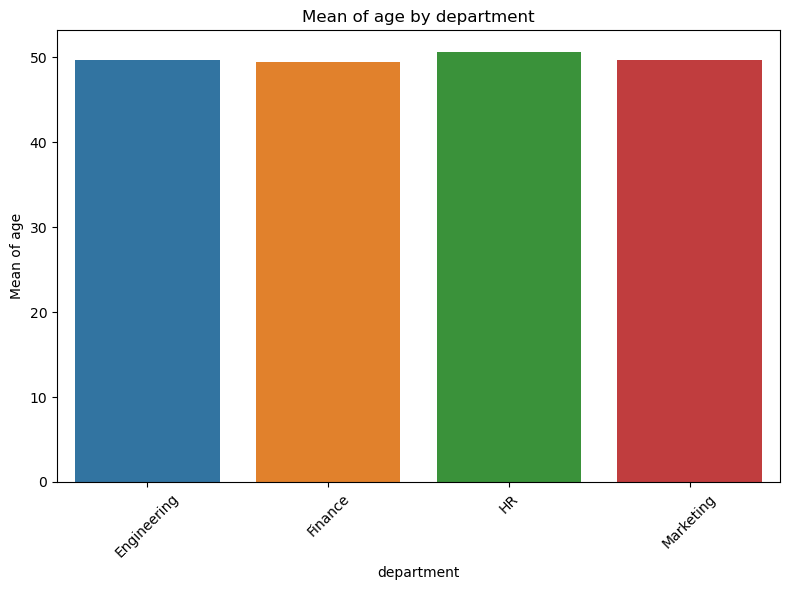

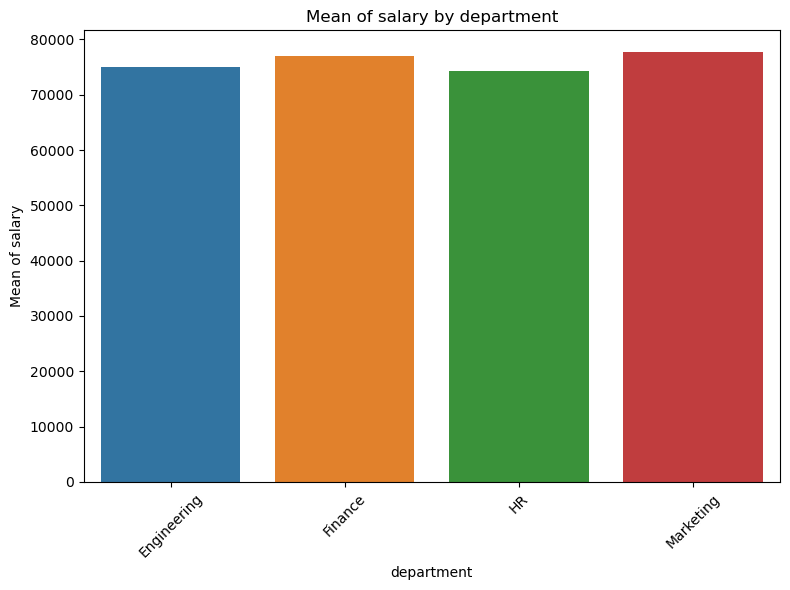

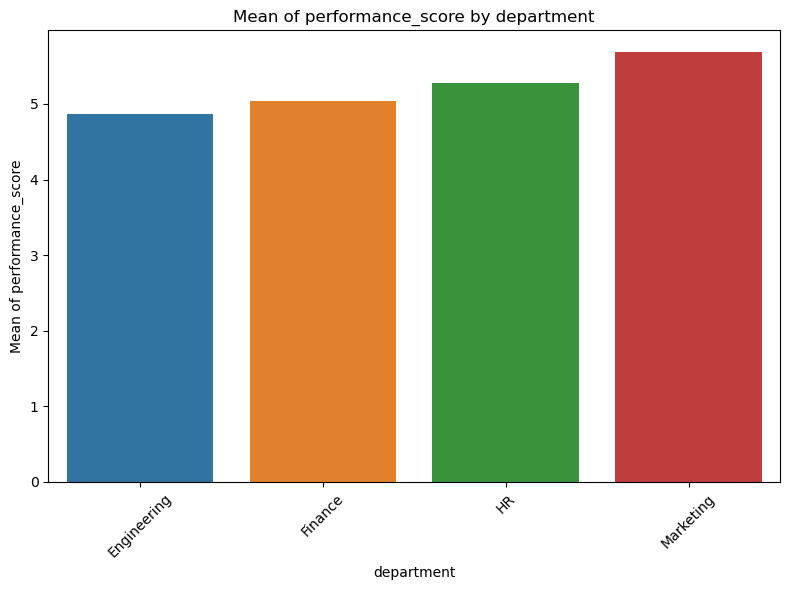

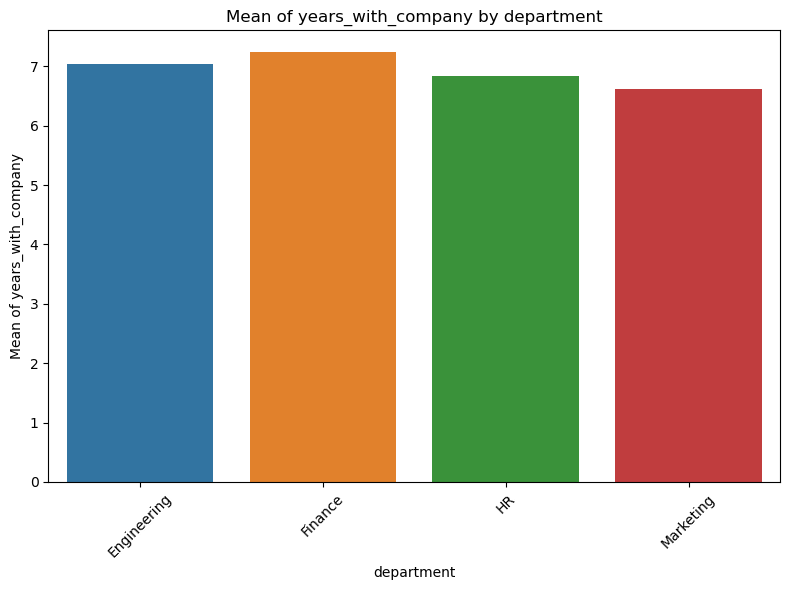

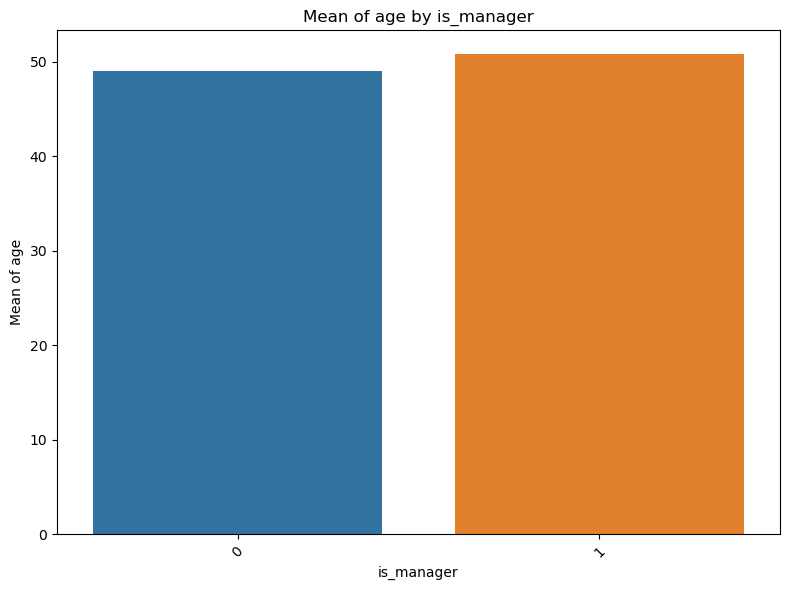

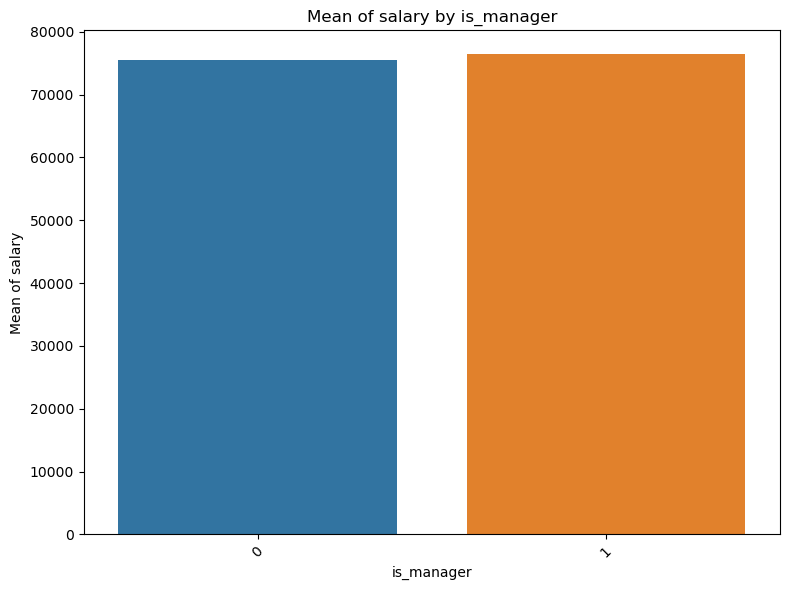

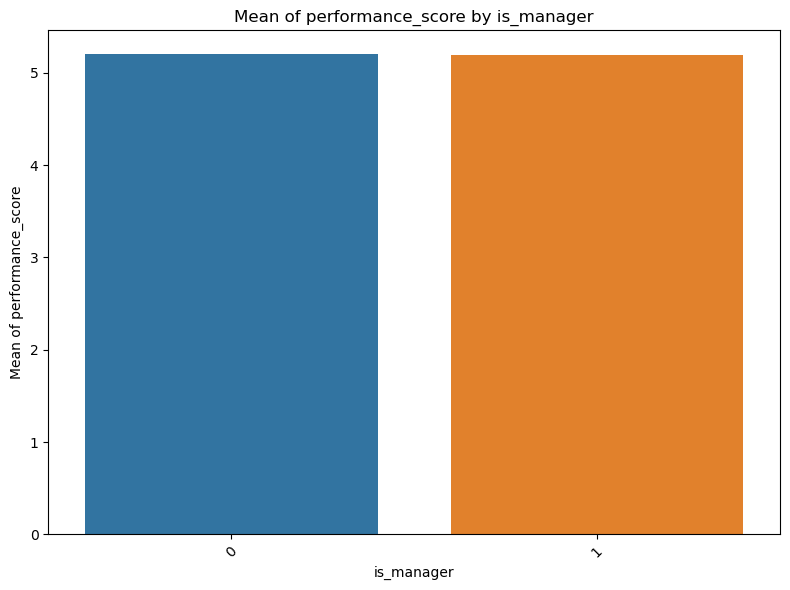

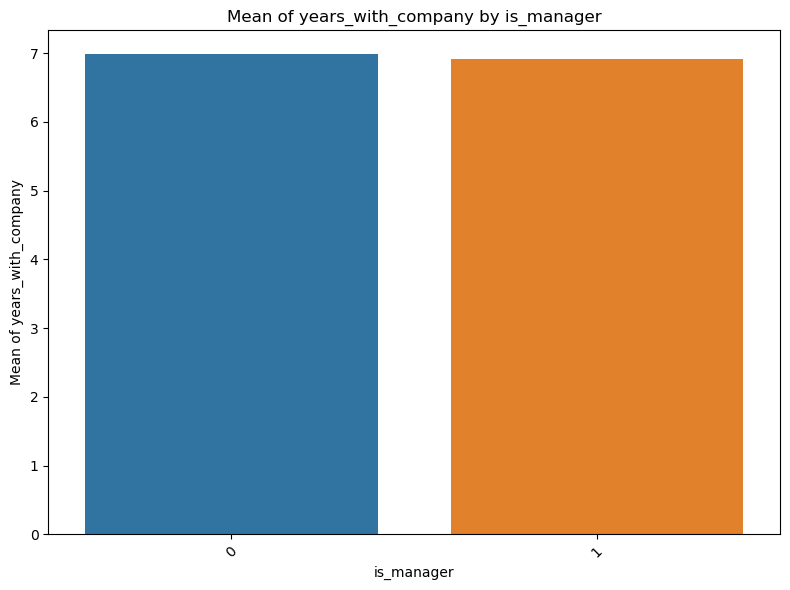

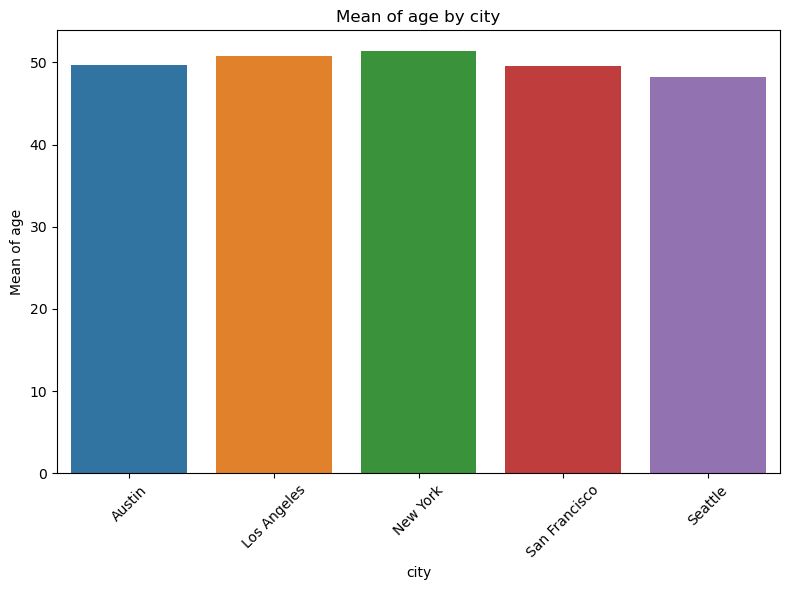

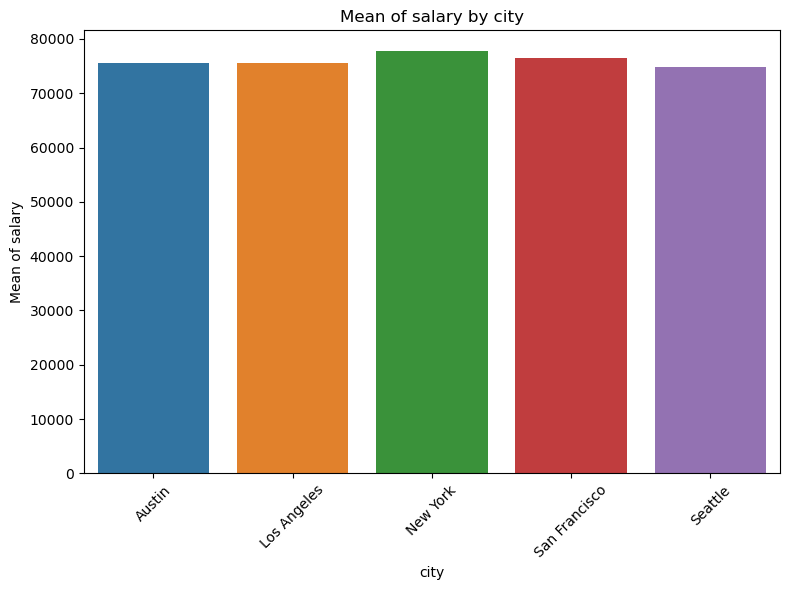

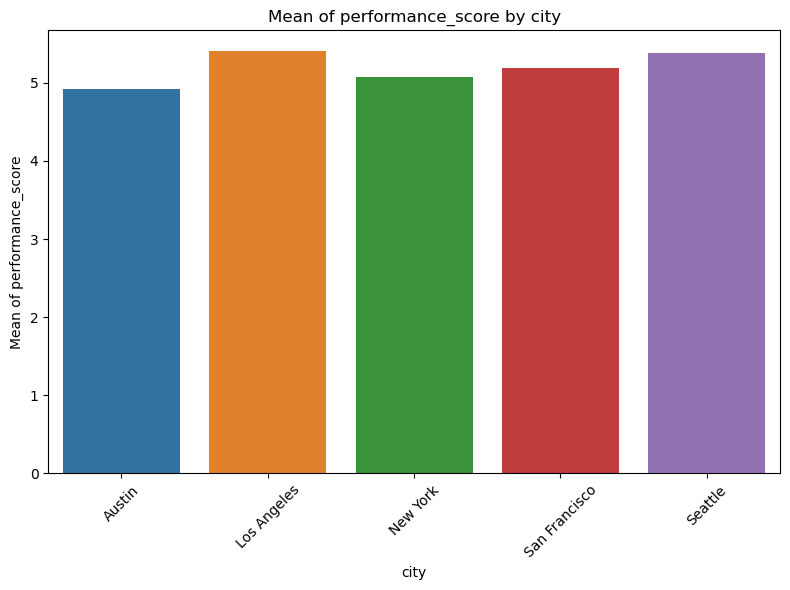

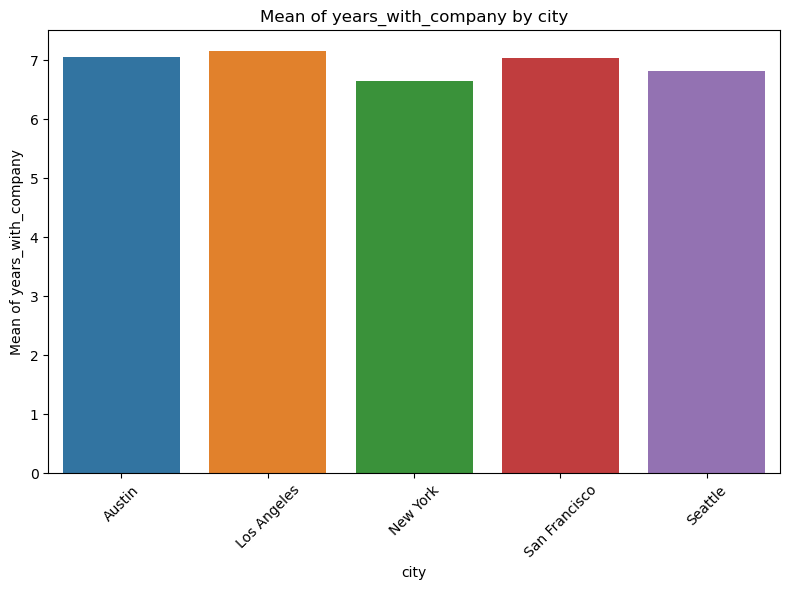

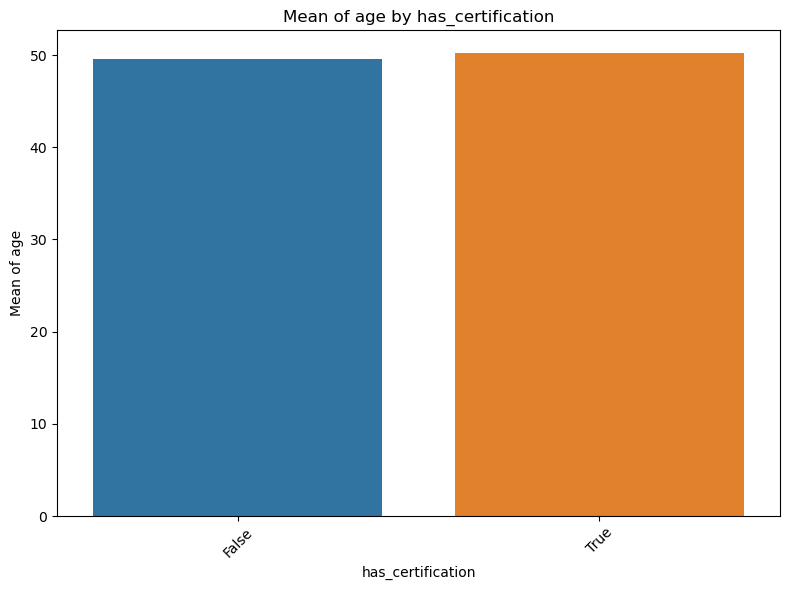

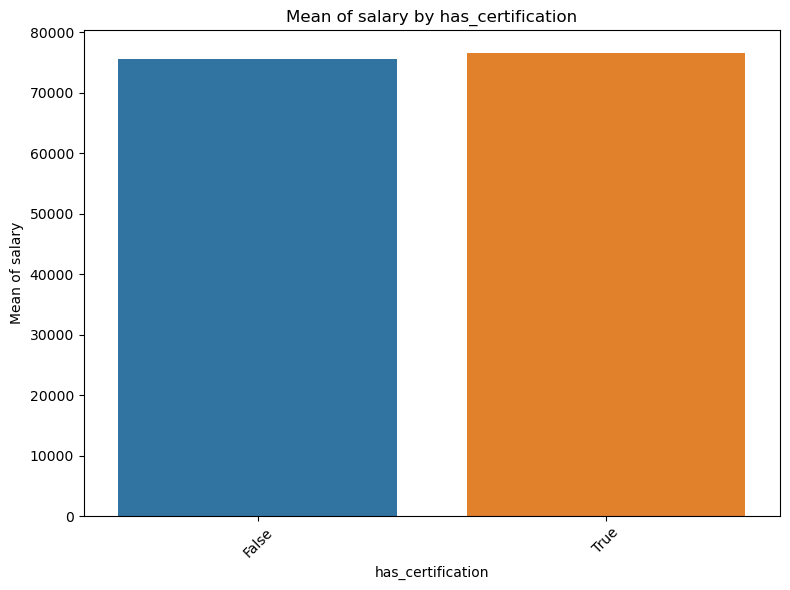

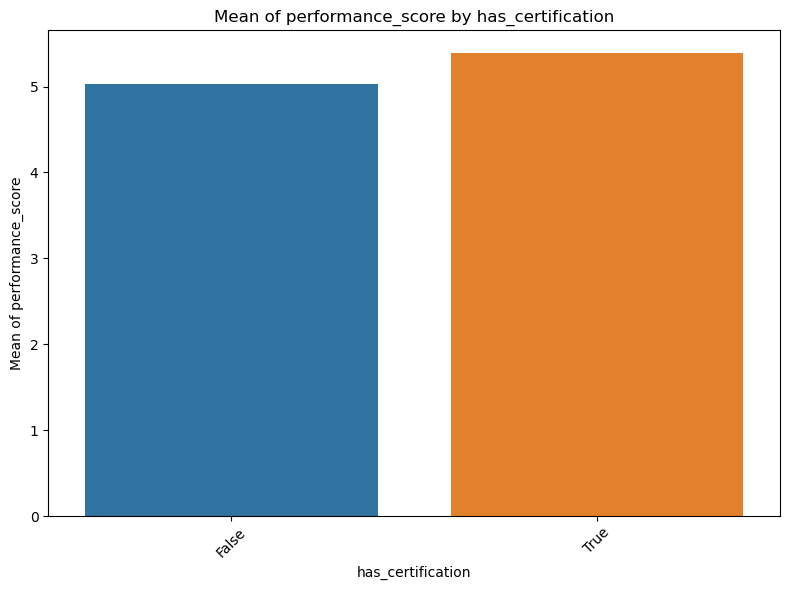

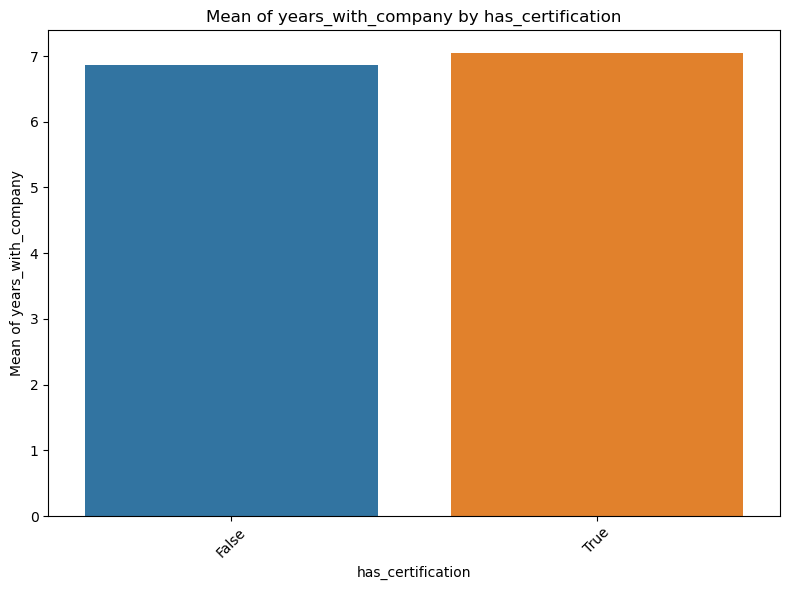

In [30]:
for col in categorical_columns:
    for num_col in numeric_columns:
        plt.figure(figsize=(8, 6))
        mean_values = df.groupby(col)[num_col].mean()
        sns.barplot(x=mean_values.index, y=mean_values.values)
        plt.title(f"Mean of {num_col} by {col}")
        plt.xlabel(col)
        plt.ylabel(f"Mean of {num_col}")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()


[Back to the top](#Contents)

#### `Correlation by Category`
Check correlations within numeric variables grouped by categories of a categorical variable.

In [31]:
if False:
    for col in categorical_columns:
        print(f"Correlation Matrix for Numeric Columns by {col} Categories:\n")
        for category in df[col].unique():
            subset = df[df[col] == category]
            correlation_matrix = subset[numeric_columns].corr()
            print(f"Category: {category}")
            print(correlation_matrix)
            print("\n" + "-"*50 + "\n")

___
[Back to the top](#Contents)